<a href="https://colab.research.google.com/github/descartesmbogning/crossref_preprint_labeling/blob/main/1_crossref_preprint_labeling_exploration%2Bnormalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import merged files

In [1]:
from google.colab import drive
drive.mount("/content/drive")
#PARQUET = '/content/drive/MyDrive/crossref_batches_2000_01_01__2025_08_30/crossref_preprints_merged/crossref_preprints_merged_20250902_125141.parquet'  # <- change me

Mounted at /content/drive


In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
# display(df)

In [3]:
import os
import glob

# Define the directory containing the parquet files
parquet_dir = '/content/drive/MyDrive/ScholCommLab/DATA/CROSSREF/crossref_batches/crossref_preprints_merged/'

# Find the latest parquet file in the directory that contains the specified substring
list_of_files = glob.glob(parquet_dir + 'crossref_preprints_merged_202*.parquet')
if not list_of_files:
    raise FileNotFoundError(f"No parquet files containing 'crossref_preprints_merged_202' found in {parquet_dir}")

latest_file = max(list_of_files, key=os.path.getctime)

# Update the PARQUET variable
PARQUET = latest_file
print(f"Updated PARQUET variable to: {PARQUET}")

Updated PARQUET variable to: /content/drive/MyDrive/ScholCommLab/DATA/CROSSREF/crossref_batches/crossref_preprints_merged/crossref_preprints_merged_20251102_204424.parquet


In [4]:
list_of_files

['/content/drive/MyDrive/ScholCommLab/DATA/CROSSREF/crossref_batches/crossref_preprints_merged/crossref_preprints_merged_20250907_153412.parquet',
 '/content/drive/MyDrive/ScholCommLab/DATA/CROSSREF/crossref_batches/crossref_preprints_merged/crossref_preprints_merged_20250911_054444.parquet',
 '/content/drive/MyDrive/ScholCommLab/DATA/CROSSREF/crossref_batches/crossref_preprints_merged/crossref_preprints_merged_20250921_140256.parquet',
 '/content/drive/MyDrive/ScholCommLab/DATA/CROSSREF/crossref_batches/crossref_preprints_merged/crossref_preprints_merged_20250924_004536.parquet',
 '/content/drive/MyDrive/ScholCommLab/DATA/CROSSREF/crossref_batches/crossref_preprints_merged/crossref_preprints_merged_20251018_052553.parquet',
 '/content/drive/MyDrive/ScholCommLab/DATA/CROSSREF/crossref_batches/crossref_preprints_merged/crossref_preprints_merged_20251102_204424.parquet']

In [65]:
!pip -q install duckdb
import duckdb

con = duckdb.connect()

# Peek schema and a few rows (no full load)
print(con.execute(f"DESCRIBE SELECT * FROM '{PARQUET}'").fetchdf())
con.execute(f"SELECT * FROM '{PARQUET}' LIMIT 5").df()

  #WHERE CAST(posted_date AS DATE) >= DATE '2020-01-01' AND subtype = 'preprint'
# Example: filter + select only needed cols, then materialize a SMALL subset
small = con.execute(f"""
  SELECT doi, posted_date, url, primary_url, type, subtype, prefix, publisher, content_domain_json, container_title, short_container_title, institution_name, is_preprint_of, has_preprint, is_version_of, group_title, member
  FROM '{PARQUET}'
  WHERE subtype = 'preprint'
  LIMIT 3_000_000
""").fetchdf()

# Save processed subset back to Drive (Parquet is recommended)
all_df = con.execute(f"""
  COPY (
    SELECT  doi, posted_date, url, primary_url, type, subtype, prefix, publisher, content_domain_json, container_title, short_container_title, institution_name, is_preprint_of, has_preprint, is_version_of, group_title, member
    FROM '{PARQUET}'
  ) TO '/content/drive/MyDrive/ScholCommLab/DATA/CROSSREF/crossref_batches/crossref_preprints_merged/filtered.parquet' (FORMAT PARQUET);
""")

               column_name column_type null   key default extra
0                      doi     VARCHAR  YES  None    None  None
1                      url     VARCHAR  YES  None    None  None
2              primary_url     VARCHAR  YES  None    None  None
3                    title     VARCHAR  YES  None    None  None
4           original_title     VARCHAR  YES  None    None  None
5              short_title     INTEGER  YES  None    None  None
6                 subtitle     VARCHAR  YES  None    None  None
7                     type     VARCHAR  YES  None    None  None
8                  subtype     VARCHAR  YES  None    None  None
9                   prefix     VARCHAR  YES  None    None  None
10               publisher     VARCHAR  YES  None    None  None
11         container_title     INTEGER  YES  None    None  None
12   short_container_title     INTEGER  YES  None    None  None
13        institution_name     VARCHAR  YES  None    None  None
14            created_date     VARCHAR  

RuntimeError: Query interrupted

# Exploration of all `posted-content` types


## Load the filtered data

Load the `filtered.parquet` file into a pandas DataFrame.


In [6]:
df_all = pd.read_parquet('/content/drive/MyDrive/ScholCommLab/DATA/CROSSREF/crossref_batches/crossref_preprints_merged/filtered.parquet')
display(df_all.head(2))

,doi,posted_date,url,primary_url,type,subtype,prefix,publisher,content_domain_json,container_title,short_container_title,institution_name,is_preprint_of,has_preprint,is_version_of,group_title,member
0,10.33015/dominican.edu/2000.hist.st.01,2000-01-01,https://doi.org/10.33015/dominican.edu/2000.hi...,https://scholar.dominican.edu/history-senior-t...,posted-content,other,10.33015,Dominican University of California,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,None,None,None,None,None,18353
1,10.47952/gro-publ-170,2000-01-01,https://doi.org/10.47952/gro-publ-170,https://resolver.sub.uni-goettingen.de/purl?gr...,posted-content,working_paper,10.47952,University Goettingen,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,None,None,None,None,None,13290


In [7]:
# Drop duplicate rows
df_filtered = df_all.drop_duplicates()

# Display the number of rows before and after dropping duplicates
print(f"Number of rows before dropping duplicates: {len(df_all)}")
print(f"Number of rows after dropping duplicates: {len(df_filtered)}")

Number of rows before dropping duplicates: 3013003
Number of rows after dropping duplicates: 2835415


In [8]:
# Make sure posted_date is datetime
df_filtered["posted_date"] = pd.to_datetime(df_filtered["posted_date"], errors="coerce")

# Get the most recent date
latest_date = df_filtered["posted_date"].max()
latest_date = latest_date.strftime('%Y-%m-%d')
print("Most recent posted_date:", latest_date)


Most recent posted_date: 2025-10-31


/tmp/ipython-input-4269541617.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["posted_date"] = pd.to_datetime(df_filtered["posted_date"], errors="coerce")


## Check for missing values

In [9]:
df_filtered.count()

,0
doi,2835415
posted_date,2835415
url,2835415
primary_url,2835415
type,2835415
subtype,2835415
prefix,2835415
publisher,2835402
content_domain_json,2835415
container_title,0


In [10]:
# Check for missing values in each column
display(df_filtered.isnull().sum())

,0
doi,0
posted_date,0
url,0
primary_url,0
type,0
subtype,0
prefix,0
publisher,13
content_domain_json,0
container_title,2835415


## count of subtypes

In [11]:
institution_counts = df_filtered['subtype'].value_counts().reset_index()
institution_counts.columns = ['subtype', 'count']
display(institution_counts)

,subtype,count
0,preprint,1946456
1,other,870788
2,dissertation,17180
3,working_paper,812
4,letter,153
5,report,26


## extract year from the `posted_date` column

Convert the `posted_date` column to datetime objects and extract year and month.


In [12]:
df_filtered['posted_date'] = pd.to_datetime(df_filtered['posted_date'], errors='coerce')
df_filtered['year'] = df_filtered['posted_date'].dt.year
df_filtered['month'] = df_filtered['posted_date'].dt.month
df_filtered.dropna(subset=['posted_date'], inplace=True)
#display(df_filtered.head())

/tmp/ipython-input-2237914454.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['posted_date'] = pd.to_datetime(df_filtered['posted_date'], errors='coerce')
/tmp/ipython-input-2237914454.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['year'] = df_filtered['posted_date'].dt.year
/tmp/ipython-input-2237914454.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [13]:
yearly_counts = df_filtered.groupby('year').size().reset_index(name='count')
display(yearly_counts.tail(10))

,year,count
65,2016,43834
66,2017,65152
67,2018,90925
68,2019,119361
69,2020,257255
70,2021,266839
71,2022,260073
72,2023,675921
73,2024,509719
74,2025,443309


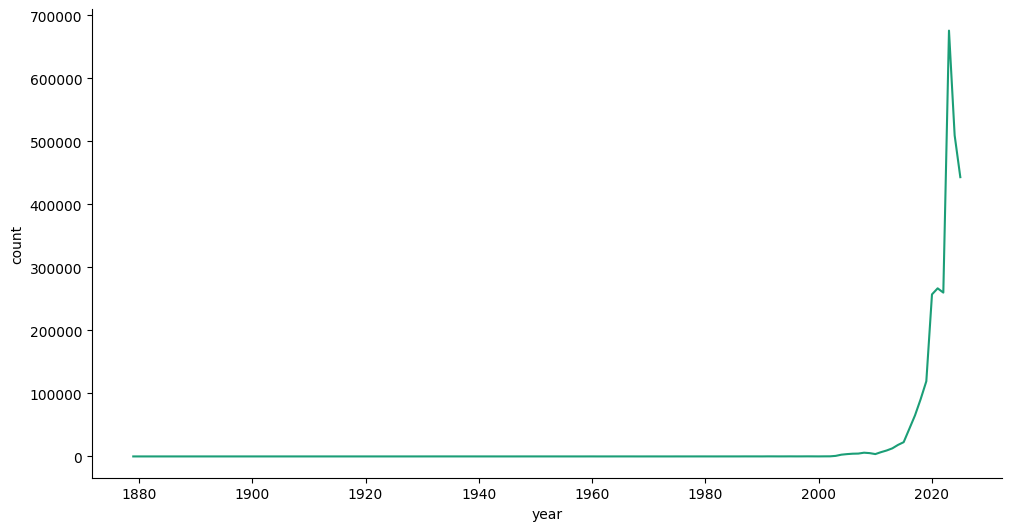

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['year']
  ys = series['count']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = yearly_counts.sort_values('year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('year')
_ = plt.ylabel('count')

## Aggregate data

Group by year, month, and `type`, and count the number of preprints for each combination.


In [15]:
preprint_counts = df_filtered.groupby(['year', 'month', 'subtype']).size().reset_index(name='count')
display(preprint_counts.tail(10))

,year,month,subtype,count
1036,2025,8,other,4153
1037,2025,8,preprint,20325
1038,2025,9,dissertation,118
1039,2025,9,other,4466
1040,2025,9,preprint,23672
1041,2025,10,dissertation,235
1042,2025,10,other,4576
1043,2025,10,preprint,23770
1044,2025,10,report,16
1045,2025,10,working_paper,1


## Pivot the data

Reshape the aggregated data to have dates as index and preprint types as columns.


In [16]:
preprint_trends = preprint_counts.pivot(index=['year', 'month'], columns='subtype', values='count').fillna(0)
display(preprint_trends.tail(24))

subtype     dissertation  letter    other  preprint  report  working_paper
year month                                                                
2023 11              4.0     1.0   4957.0   21036.0     0.0            0.0
     12             60.0     0.0   5150.0   18975.0     0.0            0.0
2024 1              20.0     0.0  15652.0  201510.0     0.0           32.0
     2             544.0     0.0   5676.0   18665.0     0.0            0.0
     3             583.0     0.0   7343.0   20256.0     0.0            0.0
     4              14.0     0.0   6000.0   19998.0     0.0            0.0
     5              34.0     0.0   8045.0   18978.0     0.0            0.0
     6             555.0     0.0   5906.0   17991.0     0.0            0.0
     7               2.0     0.0   7219.0   19927.0     1.0            0.0
     8              96.0     0.0   7247.0   20718.0     0.0            0.0
     9             507.0     0.0  14999.0   19170.0     0.0            0.0
     10            156.0     0.0   4694.0   21063.0     0.0            0.0
     11             88.0     0.0   4905.0   19134.0     0.0            0.0
     12             24.0     0.0   3707.0   18260.0     0.0            0.0
2025 1              47.0     0.0  23770.0  166100.0     0.0           21.0
     2              49.0     0.0   4155.0   15858.0     0.0            0.0
     3              71.0     0.0  24731.0   18268.0     0.0            0.0
     4             139.0     0.0   4952.0   20442.0     6.0            0.0
     5             135.0     0.0   7216.0   21803.0     0.0            0.0
     6               6.0     0.0   4314.0   20713.0     0.0            0.0
     7              26.0     0.0   7170.0   21924.0     0.0            0.0
     8              61.0     0.0   4153.0   20325.0     0.0            0.0
     9             118.0     0.0   4466.0   23672.0     0.0            0.0
     10            235.0     0.0   4576.0   23770.0    16.0            1.0

## Visualize the trends

Plot the time series of preprint counts for each type.


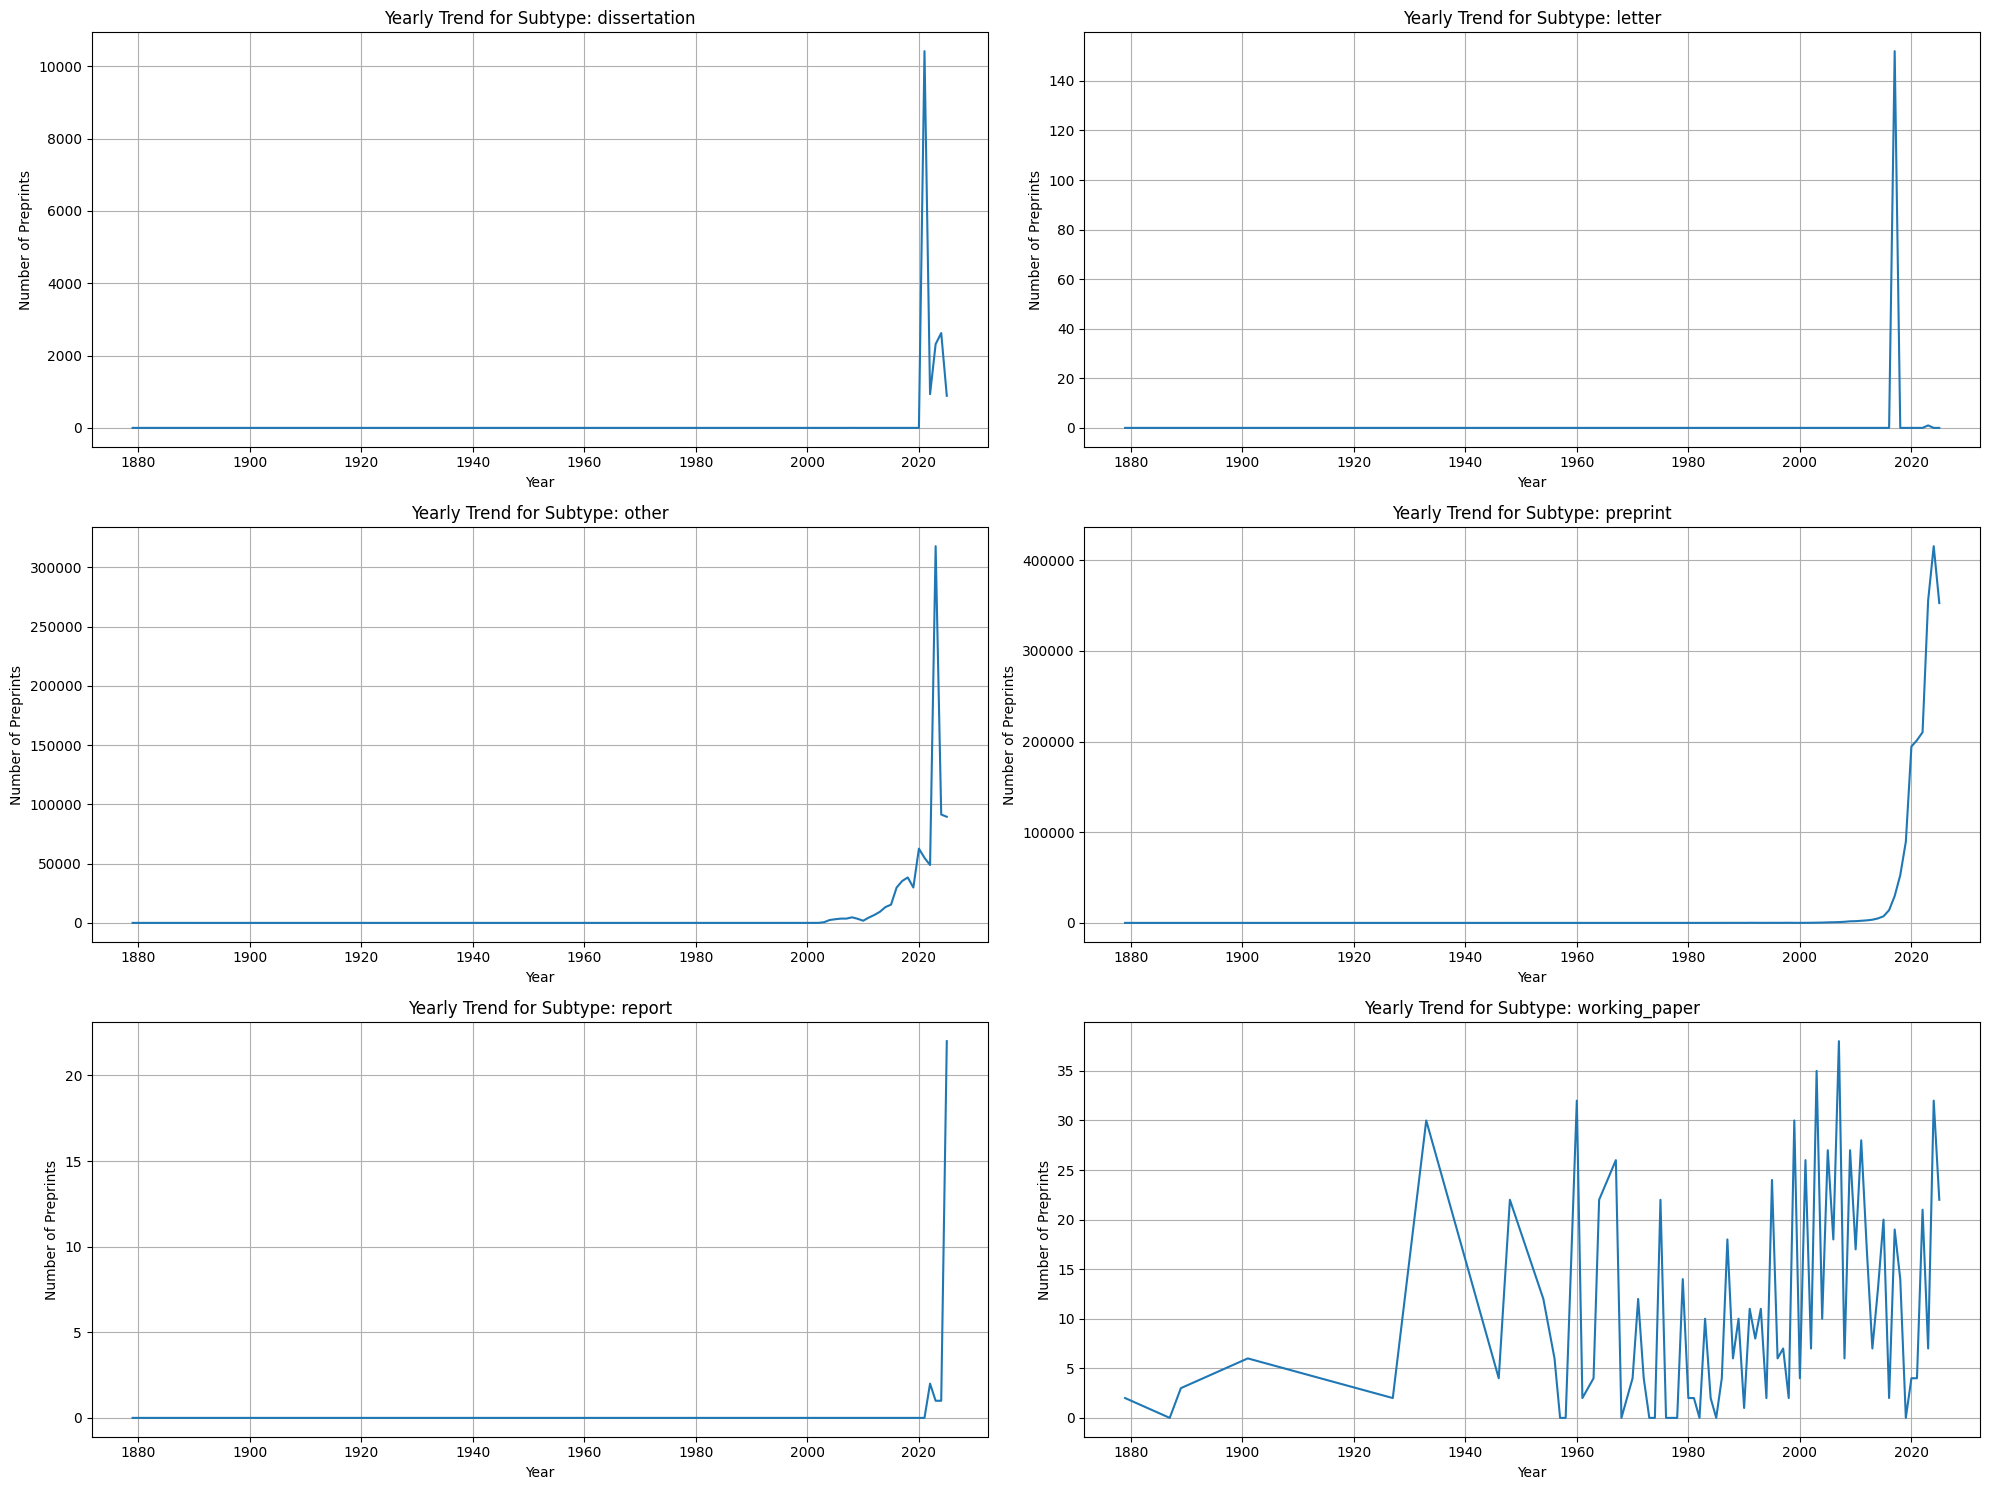

In [17]:
# Aggregate data by year and subtype
yearly_preprint_counts = df_filtered.groupby(['year', 'subtype']).size().reset_index(name='count')

# Pivot the data to have years as index and subtypes as columns
yearly_preprint_trends = yearly_preprint_counts.pivot(index='year', columns='subtype', values='count').fillna(0)

# Visualize the yearly trends for each subtype in subplots
subtypes = yearly_preprint_trends.columns
n_subtypes = len(subtypes)
n_cols = 2
n_rows = (n_subtypes + n_cols - 1) // n_cols

plt.figure(figsize=(20, n_rows * 5))

for i, subtype in enumerate(subtypes):
    plt.subplot(n_rows, n_cols, i + 1)
    yearly_preprint_trends[subtype].plot()
    plt.title(f'Yearly Trend for Subtype: {subtype}')
    plt.xlabel('Year')
    plt.ylabel('Number of Preprints')
    plt.grid(True)

plt.tight_layout()
plt.show()

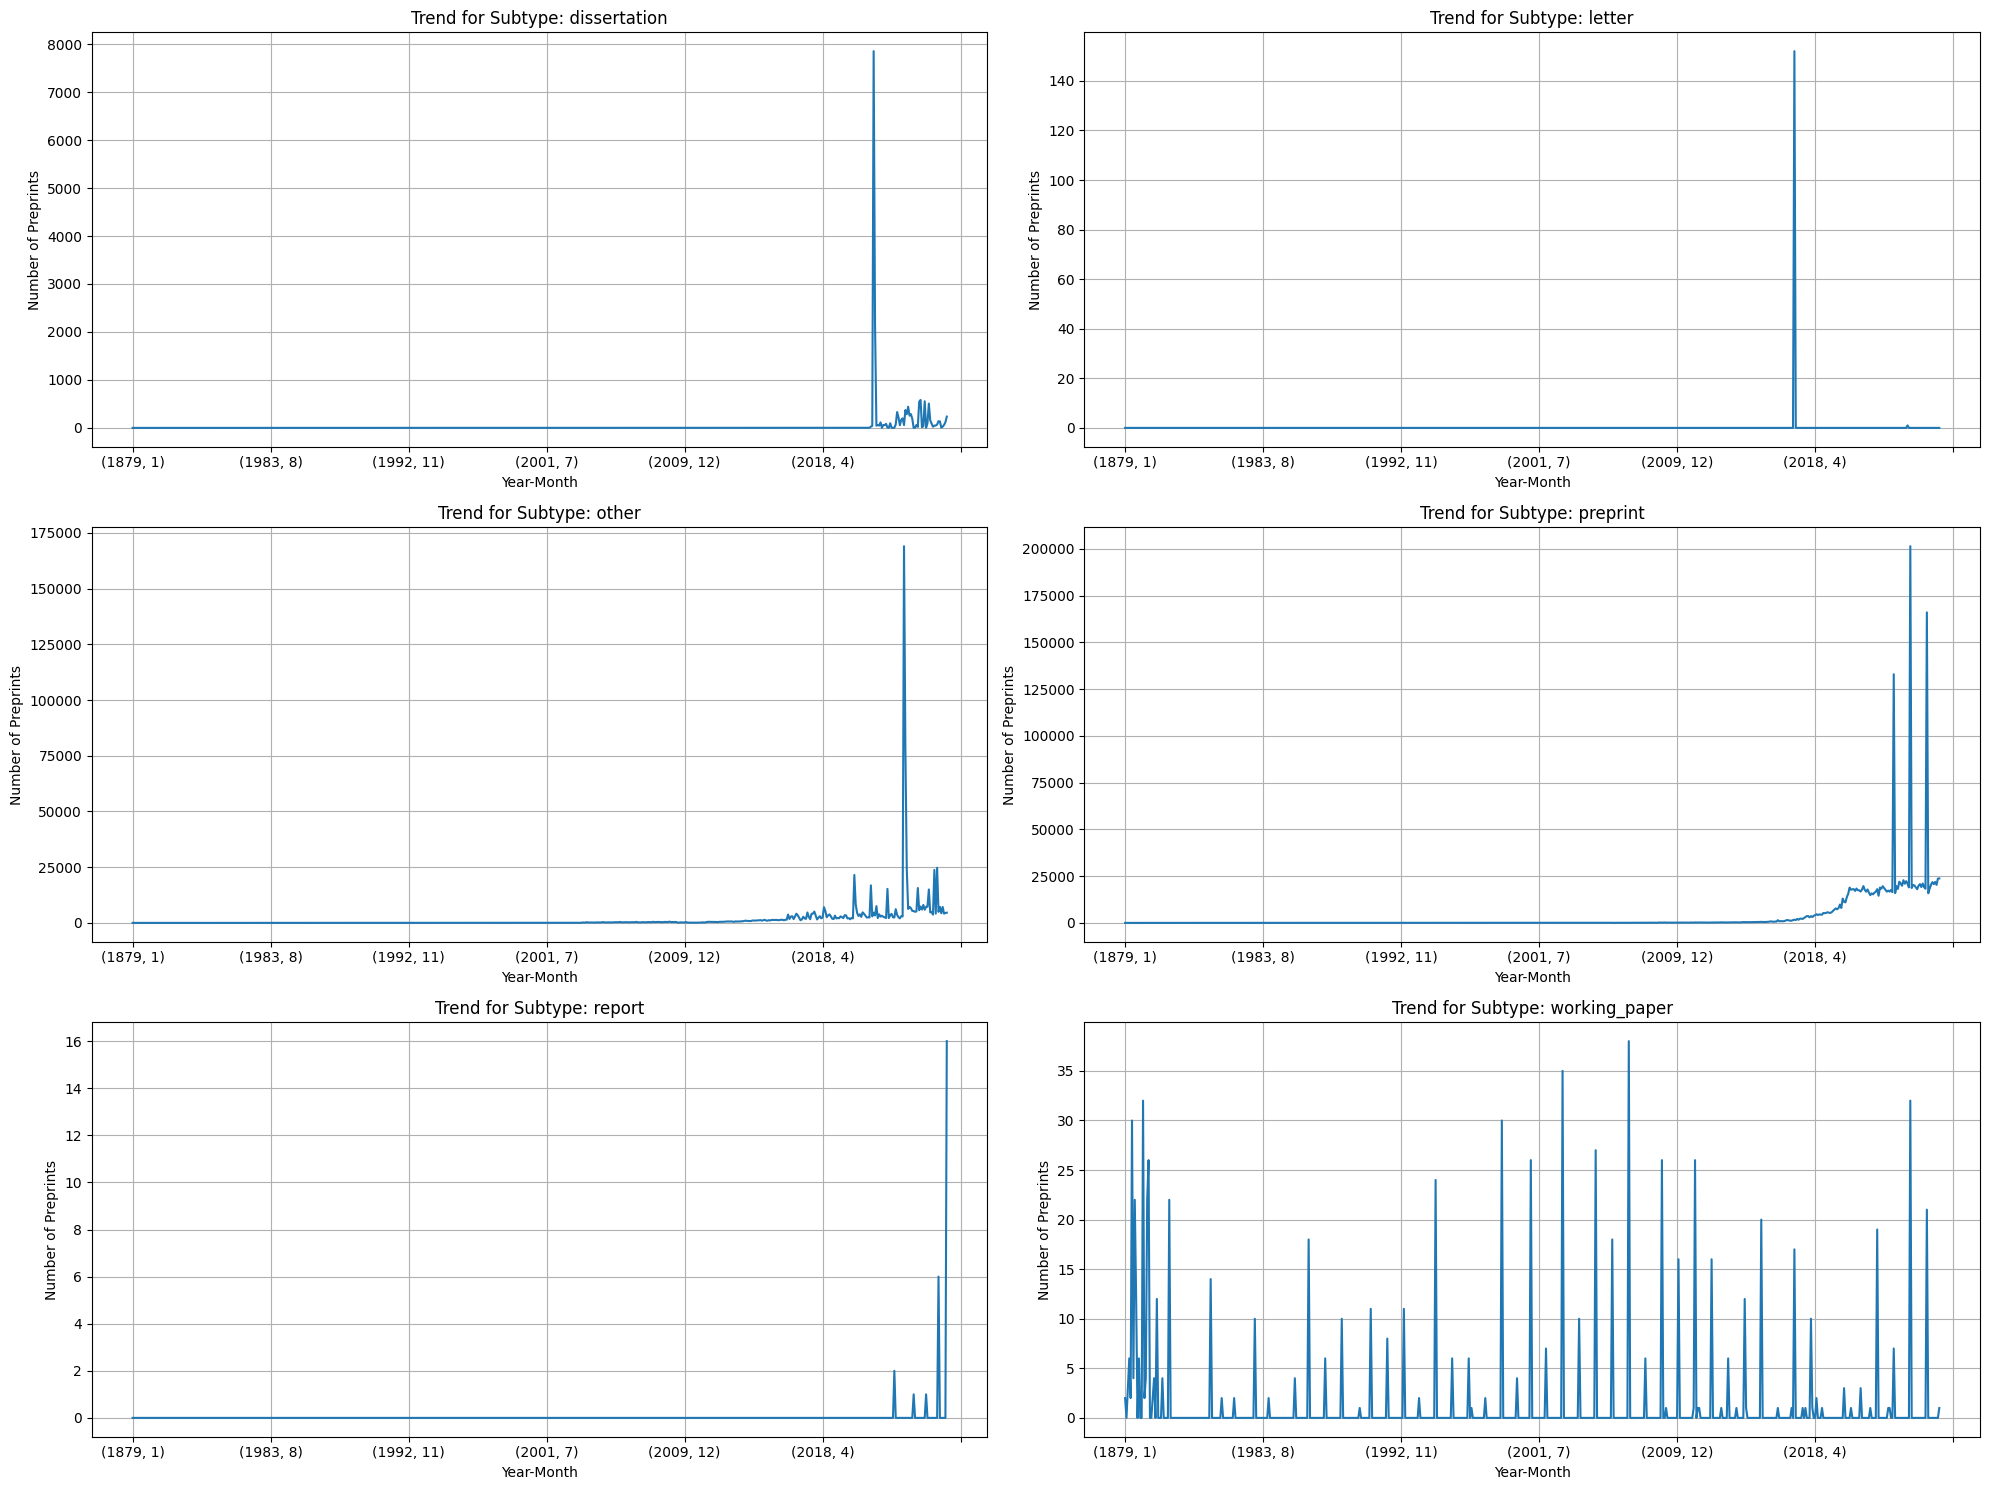

In [18]:
import matplotlib.pyplot as plt

# Get the list of subtypes
subtypes = preprint_trends.columns

# Determine the number of rows and columns for subplots
n_subtypes = len(subtypes)
n_cols = 2  # You can adjust the number of columns as needed
n_rows = (n_subtypes + n_cols - 1) // n_cols

plt.figure(figsize=(20, n_rows * 5)) # Adjust figure size based on number of rows

for i, subtype in enumerate(subtypes):
    plt.subplot(n_rows, n_cols, i + 1)
    preprint_trends[subtype].plot()
    plt.title(f'Trend for Subtype: {subtype}')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Preprints')
    plt.grid(True)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

In [19]:
for subtype in df_filtered['subtype'].unique():
    print(f"--- Subtype: {subtype} ---")
    display(df_filtered[df_filtered['subtype'] == subtype].head())

--- Subtype: other ---


,doi,posted_date,url,primary_url,type,subtype,prefix,publisher,content_domain_json,container_title,short_container_title,institution_name,is_preprint_of,has_preprint,is_version_of,group_title,member,year,month
0,10.33015/dominican.edu/2000.hist.st.01,2000-01-01,https://doi.org/10.33015/dominican.edu/2000.hi...,https://scholar.dominican.edu/history-senior-t...,posted-content,other,10.33015,Dominican University of California,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,None,None,None,None,None,18353,2000,1
15,10.17077/7a09-e5b1,2000-01-01,https://doi.org/10.17077/7a09-e5b1,https://iro.uiowa.edu/esploro/outputs/presenta...,posted-content,other,10.17077,The University of Iowa,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,University of Iowa,None,None,None,None,6626,2000,1
21,10.70220/vz4whxvs,2000-04-01,https://doi.org/10.70220/vz4whxvs,https://its.ntia.gov/publications/details?pub=...,posted-content,other,10.70220,Institute for Telecommunication Sciences,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,None,None,None,None,None,50958,2000,4
24,10.70220/sk3fh8q4,2000-05-01,https://doi.org/10.70220/sk3fh8q4,https://its.ntia.gov/publications/details?pub=...,posted-content,other,10.70220,Institute for Telecommunication Sciences,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,None,None,None,None,None,50958,2000,5
56,10.53846/goediss-2,2001-01-01,https://doi.org/10.53846/goediss-2,http://hdl.handle.net/11858/00-1735-0000-0006-...,posted-content,other,10.53846,University Goettingen Repository,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,None,None,None,None,None,32034,2001,1


--- Subtype: working_paper ---


,doi,posted_date,url,primary_url,type,subtype,prefix,publisher,content_domain_json,container_title,short_container_title,institution_name,is_preprint_of,has_preprint,is_version_of,group_title,member,year,month
1,10.47952/gro-publ-170,2000-01-01,https://doi.org/10.47952/gro-publ-170,https://resolver.sub.uni-goettingen.de/purl?gr...,posted-content,working_paper,10.47952,University Goettingen,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,None,None,None,None,None,13290,2000,1
2,10.47952/gro-publ-149,2000-01-01,https://doi.org/10.47952/gro-publ-149,https://resolver.sub.uni-goettingen.de/purl?gr...,posted-content,working_paper,10.47952,University Goettingen,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,None,None,None,None,None,13290,2000,1
3,10.59161/cipm2000rec1e,2000-01-01,https://doi.org/10.59161/cipm2000rec1e,https://www.bipm.org/en/-/committees/ci/cipm/8...,posted-content,working_paper,10.59161,Bureau International des Poids et Mesures,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,None,None,None,None,None,38096,2000,1
4,10.59161/cipm2000rec1f,2000-01-01,https://doi.org/10.59161/cipm2000rec1f,https://www.bipm.org/fr/-/committees/ci/cipm/8...,posted-content,working_paper,10.59161,Bureau International des Poids et Mesures,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,None,None,None,None,None,38096,2000,1
57,10.47952/gro-publ-169,2001-01-01,https://doi.org/10.47952/gro-publ-169,https://resolver.sub.uni-goettingen.de/purl?gr...,posted-content,working_paper,10.47952,University Goettingen,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,None,None,None,None,None,13290,2001,1


--- Subtype: preprint ---


,doi,posted_date,url,primary_url,type,subtype,prefix,publisher,content_domain_json,container_title,short_container_title,institution_name,is_preprint_of,has_preprint,is_version_of,group_title,member,year,month
5,10.18785/fa.m017,2000-01-01,https://doi.org/10.18785/fa.m017,https://specialcollections.usm.edu/repositorie...,posted-content,preprint,10.18785,University of Southern Mississippi,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,None,None,None,None,Hardy (Robert B.) Papers,7980,2000,1
6,10.18785/fa.m083,2000-01-01,https://doi.org/10.18785/fa.m083,https://specialcollections.usm.edu/repositorie...,posted-content,preprint,10.18785,University of Southern Mississippi,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,None,None,None,None,"United States....Land Patent-Mississippi, 1841.",7980,2000,1
7,10.18785/fa.m181,2000-01-01,https://doi.org/10.18785/fa.m181,https://specialcollections.usm.edu/repositorie...,posted-content,preprint,10.18785,University of Southern Mississippi,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,None,None,None,None,"Mississippi (State of) vs. W. M. McDonald, Jr.",7980,2000,1
8,10.18785/fa.m186,2000-01-01,https://doi.org/10.18785/fa.m186,https://specialcollections.usm.edu/repositorie...,posted-content,preprint,10.18785,University of Southern Mississippi,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,None,None,None,None,Nydegger Family Papers,7980,2000,1
9,10.18785/fa.m199,2000-01-01,https://doi.org/10.18785/fa.m199,https://specialcollections.usm.edu/repositorie...,posted-content,preprint,10.18785,University of Southern Mississippi,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,None,None,None,None,Stevens (Rose Budd) Papers,7980,2000,1


--- Subtype: dissertation ---


,doi,posted_date,url,primary_url,type,subtype,prefix,publisher,content_domain_json,container_title,short_container_title,institution_name,is_preprint_of,has_preprint,is_version_of,group_title,member,year,month
19020,10.7926/h2h41pbd,2008-06-01,https://doi.org/10.7926/h2h41pbd,https://middlebury.figshare.com/articles/thesi...,posted-content,dissertation,10.7926,Middlebury College Library,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,None,None,None,None,None,14696,2008,6
691638,10.26686/wgtn.14033225.v1,2021-02-15,https://doi.org/10.26686/wgtn.14033225.v1,https://openaccess.wgtn.ac.nz/articles/thesis/...,posted-content,dissertation,10.26686,Victoria University of Wellington Library,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,None,None,None,None,None,11224,2021,2
695935,10.26686/wgtn.14068520.v1,2021-02-22,https://doi.org/10.26686/wgtn.14068520.v1,https://openaccess.wgtn.ac.nz/articles/thesis/...,posted-content,dissertation,10.26686,Victoria University of Wellington Library,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,None,None,None,None,None,11224,2021,2
701180,10.26686/wgtn.14138144.v1,2021-03-01,https://doi.org/10.26686/wgtn.14138144.v1,https://openaccess.wgtn.ac.nz/articles/thesis/...,posted-content,dissertation,10.26686,Victoria University of Wellington Library,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,None,None,None,None,None,11224,2021,3
707826,10.26686/wgtn.14159408.v2,2021-03-07,https://doi.org/10.26686/wgtn.14159408.v2,https://openaccess.wgtn.ac.nz/articles/thesis/...,posted-content,dissertation,10.26686,Victoria University of Wellington Library,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,None,None,None,None,None,11224,2021,3


--- Subtype: letter ---


,doi,posted_date,url,primary_url,type,subtype,prefix,publisher,content_domain_json,container_title,short_container_title,institution_name,is_preprint_of,has_preprint,is_version_of,group_title,member,year,month
145274,10.14711/spcol/x001211,2017-01-01,https://doi.org/10.14711/spcol/x001211,http://lbezone.ust.hk/bib/x001211,posted-content,letter,10.14711,The Hong Kong University of Science and Techno...,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,The Hong Kong University of Science and Techno...,None,None,None,Paul Lin and Soong Ching-ling Correspondence,5801,2017,1
145275,10.14711/spcol/x001224,2017-01-01,https://doi.org/10.14711/spcol/x001224,http://lbezone.ust.hk/bib/x001224,posted-content,letter,10.14711,The Hong Kong University of Science and Techno...,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,The Hong Kong University of Science and Techno...,None,None,None,Paul Lin and Soong Ching-ling Correspondence,5801,2017,1
145276,10.14711/spcol/x001225,2017-01-01,https://doi.org/10.14711/spcol/x001225,http://lbezone.ust.hk/bib/x001225,posted-content,letter,10.14711,The Hong Kong University of Science and Techno...,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,The Hong Kong University of Science and Techno...,None,None,None,Paul Lin and Soong Ching-ling Correspondence,5801,2017,1
145277,10.14711/spcol/x001234,2017-01-01,https://doi.org/10.14711/spcol/x001234,http://lbezone.ust.hk/bib/x001234,posted-content,letter,10.14711,The Hong Kong University of Science and Techno...,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,The Hong Kong University of Science and Techno...,None,None,None,Paul Lin and Soong Ching-ling Correspondence,5801,2017,1
145278,10.14711/spcol/x001237,2017-01-01,https://doi.org/10.14711/spcol/x001237,http://lbezone.ust.hk/bib/x001237,posted-content,letter,10.14711,The Hong Kong University of Science and Techno...,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,The Hong Kong University of Science and Techno...,None,None,None,Paul Lin and Soong Ching-ling Correspondence,5801,2017,1


--- Subtype: report ---


,doi,posted_date,url,primary_url,type,subtype,prefix,publisher,content_domain_json,container_title,short_container_title,institution_name,is_preprint_of,has_preprint,is_version_of,group_title,member,year,month
1072021,10.58234/82222234,2022-08-18,https://doi.org/10.58234/82222234,https://impactcollaboratory.org/the-2021-2022-...,posted-content,report,10.58234,NIA IMPACT Collaboratory at Marcus Institute f...,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,NIA IMPACT Collaboratory,None,None,None,None,36707,2022,8
1072022,10.58234/92591162,2022-08-18,https://doi.org/10.58234/92591162,https://impactcollaboratory.org/the-2021-2022-...,posted-content,report,10.58234,NIA IMPACT Collaboratory at Marcus Institute f...,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,NIA IMPACT Collaboratory,None,None,None,None,36707,2022,8
1402166,10.58234/23680579,2023-10-03,https://doi.org/10.58234/23680579,https://impactcollaboratory.org/the-2022-2023-...,posted-content,report,10.58234,NIA IMPACT Collaboratory at Marcus Institute f...,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,NIA IMPACT Collaboratory,None,None,None,None,36707,2023,10
1643637,10.58234/35429703,2024-07-10,https://doi.org/10.58234/35429703,https://impactcollaboratory.org/lep-report-pcr...,posted-content,report,10.58234,NIA IMPACT Collaboratory at Marcus Institute f...,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,NIA IMPACT Collaboratory,None,None,None,None,36707,2024,7
1880007,10.64393/balagha-corpus.9286124,2025-04-23,https://doi.org/10.64393/balagha-corpus.9286124,https://balagha-corpus.com/1,posted-content,report,10.64393,The Balagha Corpus,"{""crossmark-restriction"": false, ""domain"": []}",NaN,NaN,The Balagha Corpus,None,None,None,None,53832,2025,4


# Exploration of `preprint`s subtype

## Data Exploration

In [20]:
# Drop duplicate rows
small_unique = small.drop_duplicates()

# Display the number of rows before and after dropping duplicates
print(f"Number of rows before dropping duplicates: {len(small)}")
print(f"Number of rows after dropping duplicates: {len(small_unique)}")

Number of rows before dropping duplicates: 2025265
Number of rows after dropping duplicates: 1946456


In [21]:
df = small_unique.copy()

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1946456 entries, 0 to 2025264
Data columns (total 17 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   doi                    object
 1   posted_date            object
 2   url                    object
 3   primary_url            object
 4   type                   object
 5   subtype                object
 6   prefix                 object
 7   publisher              object
 8   content_domain_json    object
 9   container_title        Int32 
 10  short_container_title  Int32 
 11  institution_name       object
 12  is_preprint_of         object
 13  has_preprint           object
 14  is_version_of          object
 15  group_title            object
 16  member                 object
dtypes: Int32(2), object(15)
memory usage: 256.2+ MB


## Check for missing values

In [23]:
df.count()

,0
doi,1946456
posted_date,1946456
url,1946456
primary_url,1946456
type,1946456
subtype,1946456
prefix,1946456
publisher,1946454
content_domain_json,1946456
container_title,0


In [24]:
# Check for missing values in each column
display(df.isnull().sum())

,0
doi,0
posted_date,0
url,0
primary_url,0
type,0
subtype,0
prefix,0
publisher,2
content_domain_json,0
container_title,1946456


## Explore `institution_name` column



### get the list and count

In [25]:
institution_counts = df['institution_name'].value_counts().reset_index()
institution_counts.columns = ['institution_name', 'count']
display(institution_counts)

,institution_name,count
0,Research Square,415078
1,bioRxiv,303619
2,medRxiv,74580
3,"Authorea, Inc.",43320
4,Authorea Inc.,21043
...,...,...
81,Balliol College,1
82,Instituto Brasileiro de Informação em Ciência ...,1
83,figshare,1
84,Lear Review,1


In [26]:
display(institution_counts.head(60))

,institution_name,count
0,Research Square,415078
1,bioRxiv,303619
2,medRxiv,74580
3,"Authorea, Inc.",43320
4,Authorea Inc.,21043
5,TechRxiv,15034
6,Earth and Space Science Open Archive,9460
7,Techrxiv,8964
8,ESS Open Archive,5590
9,Optica Open,4464


### Find potential duplicates using fuzzy matching

In [27]:
!pip install fuzzywuzzy python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 52.6 MB/s eta 0:00:00


In [28]:
from fuzzywuzzy import process

# Get the list of unique institution_name
institution_names = institution_counts['institution_name'].unique()

# Find potential duplicates using fuzzy matching
# You can adjust the threshold (e.g., 80) based on how similar names should be to be considered duplicates
potential_duplicates = []
for name in institution_names:
    matches = process.extract(name, institution_names, limit=None)
    # Filter matches that are similar but not the exact same name, and exceed the threshold
    similar_matches = [(match, score) for match, score in matches if score > 90 and match != name]
    if similar_matches:
        potential_duplicates.append((name, similar_matches))

# Print potential duplicates
if potential_duplicates:
    print("Potential duplicate institution_names (using fuzzy matching):")
    for name, matches in potential_duplicates:
        print(f"- '{name}' is similar to: {matches}")
else:
    print("No potential duplicate institution_names found using fuzzy matching (threshold > 80).")

Potential duplicate institution_names (using fuzzy matching):
- 'Authorea, Inc.' is similar to: [('Authorea Inc.', 96)]
- 'Authorea Inc.' is similar to: [('Authorea, Inc.', 96)]
- 'TechRxiv' is similar to: [('Techrxiv', 100)]
- 'Techrxiv' is similar to: [('TechRxiv', 100)]
- 'British Library' is similar to: [('The British Library', 95)]
- 'Instituto Brasileiro de Informação em Ciência e Tecnologia Ibict' is similar to: [('Instituto Brasileiro de Informação em Ciência e Tecnologia (Ibict)', 99)]
- 'Syndics of Cambridge University Library' is similar to: [('Cambridge University Library', 95)]
- 'The British Library' is similar to: [('British Library', 95)]
- 'Cambridge University Library' is similar to: [('Syndics of Cambridge University Library', 95)]
- 'Instituto Brasileiro de Informação em Ciência e Tecnologia (Ibict)' is similar to: [('Instituto Brasileiro de Informação em Ciência e Tecnologia Ibict', 99)]


### Explore of the rows where `institution_name` is missing

In [29]:
# Filter the DataFrame to get rows where 'institution_name' is missing
no_institution_df = df[df['institution_name'].isnull()]

# Display the first few rows of the filtered DataFrame
display(no_institution_df.head())

# Print the number of rows where 'institution_name' is missing
print(f"Number of rows with missing institution_name: {len(no_institution_df)}")

,doi,posted_date,url,primary_url,type,subtype,prefix,publisher,content_domain_json,container_title,short_container_title,institution_name,is_preprint_of,has_preprint,is_version_of,group_title,member
0,10.18785/fa.m017,2000-01-01,https://doi.org/10.18785/fa.m017,https://specialcollections.usm.edu/repositorie...,posted-content,preprint,10.18785,University of Southern Mississippi,"{""crossmark-restriction"": false, ""domain"": []}",<NA>,<NA>,None,None,None,None,Hardy (Robert B.) Papers,7980
1,10.18785/fa.m083,2000-01-01,https://doi.org/10.18785/fa.m083,https://specialcollections.usm.edu/repositorie...,posted-content,preprint,10.18785,University of Southern Mississippi,"{""crossmark-restriction"": false, ""domain"": []}",<NA>,<NA>,None,None,None,None,"United States....Land Patent-Mississippi, 1841.",7980
2,10.18785/fa.m181,2000-01-01,https://doi.org/10.18785/fa.m181,https://specialcollections.usm.edu/repositorie...,posted-content,preprint,10.18785,University of Southern Mississippi,"{""crossmark-restriction"": false, ""domain"": []}",<NA>,<NA>,None,None,None,None,"Mississippi (State of) vs. W. M. McDonald, Jr.",7980
3,10.18785/fa.m186,2000-01-01,https://doi.org/10.18785/fa.m186,https://specialcollections.usm.edu/repositorie...,posted-content,preprint,10.18785,University of Southern Mississippi,"{""crossmark-restriction"": false, ""domain"": []}",<NA>,<NA>,None,None,None,None,Nydegger Family Papers,7980
4,10.18785/fa.m199,2000-01-01,https://doi.org/10.18785/fa.m199,https://specialcollections.usm.edu/repositorie...,posted-content,preprint,10.18785,University of Southern Mississippi,"{""crossmark-restriction"": false, ""domain"": []}",<NA>,<NA>,None,None,None,None,Stevens (Rose Budd) Papers,7980


Number of rows with missing institution_name: 1030351


In [30]:
no_institution_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1030351 entries, 0 to 2025262
Data columns (total 17 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   doi                    1030351 non-null  object
 1   posted_date            1030351 non-null  object
 2   url                    1030351 non-null  object
 3   primary_url            1030351 non-null  object
 4   type                   1030351 non-null  object
 5   subtype                1030351 non-null  object
 6   prefix                 1030351 non-null  object
 7   publisher              1030349 non-null  object
 8   content_domain_json    1030351 non-null  object
 9   container_title        0 non-null        Int32 
 10  short_container_title  0 non-null        Int32 
 11  institution_name       0 non-null        object
 12  is_preprint_of         185127 non-null   object
 13  has_preprint           1215 non-null     object
 14  is_version_of          47995 non-null  

## Explore `content_domain_json` column



In [31]:
content_domain_counts = df['content_domain_json'].value_counts().reset_index()
content_domain_counts.columns = ['content_domain_json', 'count']
display(content_domain_counts)

,content_domain_json,count
0,"{""crossmark-restriction"": false, ""domain"": []}",1946441
1,"{""crossmark-restriction"": false, ""domain"": [""v...",14
2,"{""crossmark-restriction"": false, ""domain"": [""e...",1


In [32]:
content_domain_counts['content_domain_json'][1]

'{"crossmark-restriction": false, "domain": ["verixiv.org"]}'

In [33]:
df[df['content_domain_json']==content_domain_counts['content_domain_json'][1]]

,doi,posted_date,url,primary_url,type,subtype,prefix,publisher,content_domain_json,container_title,short_container_title,institution_name,is_preprint_of,has_preprint,is_version_of,group_title,member
1207973,10.12688/verixiv.15.1,2024-08-20,https://doi.org/10.12688/verixiv.15.1,https://verixiv.org/articles/1-1/v1,posted-content,preprint,10.12688,F1000 Research Ltd,"{""crossmark-restriction"": false, ""domain"": [""v...",<NA>,<NA>,None,None,None,10.12688/verixiv.15.2,Gates Foundation,2560
1207974,10.12688/verixiv.27.1,2024-08-20,https://doi.org/10.12688/verixiv.27.1,https://verixiv.org/articles/1-3/v1,posted-content,preprint,10.12688,F1000 Research Ltd,"{""crossmark-restriction"": false, ""domain"": [""v...",<NA>,<NA>,None,None,None,None,Gates Foundation,2560
1208268,10.12688/verixiv.29.1,2024-08-20,https://doi.org/10.12688/verixiv.29.1,https://verixiv.org/articles/1-2/v1,posted-content,preprint,10.12688,F1000 Research Ltd,"{""crossmark-restriction"": false, ""domain"": [""v...",<NA>,<NA>,None,None,None,10.12688/verixiv.29.2,Gates Foundation,2560
1208660,10.12688/verixiv.39.1,2024-08-21,https://doi.org/10.12688/verixiv.39.1,https://verixiv.org/articles/1-4/v1,posted-content,preprint,10.12688,F1000 Research Ltd,"{""crossmark-restriction"": false, ""domain"": [""v...",<NA>,<NA>,None,None,None,None,Gates Foundation,2560
1208661,10.12688/verixiv.31.1,2024-08-21,https://doi.org/10.12688/verixiv.31.1,https://verixiv.org/articles/1-5/v1,posted-content,preprint,10.12688,F1000 Research Ltd,"{""crossmark-restriction"": false, ""domain"": [""v...",<NA>,<NA>,None,None,None,10.12688/verixiv.31.2,Gates Foundation,2560
1208662,10.12688/verixiv.41.1,2024-08-21,https://doi.org/10.12688/verixiv.41.1,https://verixiv.org/articles/1-6/v1,posted-content,preprint,10.12688,F1000 Research Ltd,"{""crossmark-restriction"": false, ""domain"": [""v...",<NA>,<NA>,None,None,None,None,Gates Foundation,2560
1214938,10.12688/verixiv.54.1,2024-08-29,https://doi.org/10.12688/verixiv.54.1,https://verixiv.org/articles/1-7/v1,posted-content,preprint,10.12688,F1000 Research Ltd,"{""crossmark-restriction"": false, ""domain"": [""v...",<NA>,<NA>,None,10.12688/gatesopenres.16314.1,None,None,Gates Foundation,2560
1221929,10.12688/verixiv.24.1,2024-09-09,https://doi.org/10.12688/verixiv.24.1,https://verixiv.org/articles/1-8/v1,posted-content,preprint,10.12688,F1000 Research Ltd,"{""crossmark-restriction"": false, ""domain"": [""v...",<NA>,<NA>,None,None,None,10.12688/verixiv.24.2,Gates Foundation,2560
1226252,10.12688/verixiv.77.1,2024-09-17,https://doi.org/10.12688/verixiv.77.1,https://verixiv.org/articles/1-9/v1,posted-content,preprint,10.12688,F1000 Research Ltd,"{""crossmark-restriction"": false, ""domain"": [""v...",<NA>,<NA>,None,None,None,10.12688/verixiv.77.2; 10.12688/verixiv.77.3,Gates Foundation,2560
1226909,10.12688/verixiv.31.2,2024-09-18,https://doi.org/10.12688/verixiv.31.2,https://verixiv.org/articles/1-5/v2,posted-content,preprint,10.12688,F1000 Research Ltd,"{""crossmark-restriction"": false, ""domain"": [""v...",<NA>,<NA>,None,None,None,None,Gates Foundation,2560


In [34]:
content_domain_counts['content_domain_json'][2]

'{"crossmark-restriction": false, "domain": ["elifesciences.org"]}'

In [35]:
df[df['content_domain_json']==content_domain_counts['content_domain_json'][2]]

,doi,posted_date,url,primary_url,type,subtype,prefix,publisher,content_domain_json,container_title,short_container_title,institution_name,is_preprint_of,has_preprint,is_version_of,group_title,member
1151532,10.7554/elife.87297.4,2024-05-21,https://doi.org/10.7554/elife.87297.4,https://elifesciences.org/reviewed-preprints/8...,posted-content,preprint,10.7554,"eLife Sciences Publications, Ltd","{""crossmark-restriction"": false, ""domain"": [""e...",<NA>,<NA>,None,None,10.1101/2022.12.31.522374,10.1101/2022.12.31.522374; 10.7554/eLife.87297...,None,4374


## Explore `group_title` column



### preprint data

In [36]:
print(f"Number of rows with missing group_title: {df['group_title'].isnull().sum()}")

Number of rows with missing group_title: 100120


In [37]:
group_title_counts_df = df['group_title'].value_counts().reset_index()
group_title_counts_df.columns = ['group_title', 'count']
display(group_title_counts_df)

,group_title,count
0,SSRN,443583
1,In Review,436156
2,Open Science Framework,103422
3,Preprints,79674
4,PsyArXiv,54972
...,...,...
5053,Cherry Wilder Papers,1
5054,Lee Wyndham Papers,1
5055,Numerical Models/Surface/Deep Seas: Indian Oce...,1
5056,Shelf-sea depth/Numerical Models/Indonesian Se...,1


In [38]:
display(group_title_counts_df.head(60))

,group_title,count
0,SSRN,443583
1,In Review,436156
2,Open Science Framework,103422
3,Preprints,79674
4,PsyArXiv,54972
5,Neuroscience,54496
6,Chemistry,44779
7,Microbiology,28723
8,Bioinformatics,26090
9,SocArXiv,20769


### no_institution_df

In [39]:
print(f"Number of rows with missing group_title: {no_institution_df['group_title'].isnull().sum()}")

Number of rows with missing group_title: 67917


In [40]:
group_title_counts = no_institution_df['group_title'].value_counts().reset_index()
group_title_counts.columns = ['group_title', 'count']
display(group_title_counts)

,group_title,count
0,SSRN,443583
1,Open Science Framework,103422
2,PsyArXiv,54972
3,Chemistry,44779
4,In Review,21762
...,...,...
4938,ESSD – Geosphere/Geophysics,1
4939,Citizen science/Science engagement and dialogue,1
4940,Geoscience policy/The role of scientists,1
4941,ESSD – Atmosphere/Energy and anthropogenic emi...,1


In [41]:
display(group_title_counts.head(60))

,group_title,count
0,SSRN,443583
1,Open Science Framework,103422
2,PsyArXiv,54972
3,Chemistry,44779
4,In Review,21762
5,SocArXiv,20769
6,INA-Rxiv,17837
7,Biology and Life Sciences,15001
8,Medicine and Pharmacology,13931
9,Engineering,11373


## Explore `publisher` column



In [42]:
df[df['publisher'].isna()]

,doi,posted_date,url,primary_url,type,subtype,prefix,publisher,content_domain_json,container_title,short_container_title,institution_name,is_preprint_of,has_preprint,is_version_of,group_title,member
1443713,10.64748/zc8n2x20,2025-08-25,https://doi.org/10.64748/zc8n2x20,https://subscholar.org/preprints/preprint/view...,posted-content,preprint,10.64748,None,"{""crossmark-restriction"": false, ""domain"": []}",<NA>,<NA>,None,None,None,None,None,None
1443717,10.64748/q308ne29,2025-08-25,https://doi.org/10.64748/q308ne29,https://subscholar.org/preprints/preprint/view...,posted-content,preprint,10.64748,None,"{""crossmark-restriction"": false, ""domain"": []}",<NA>,<NA>,None,None,None,None,None,None


### preprint data

In [43]:
print(f"Number of rows with missing publisher: {df['publisher'].isnull().sum()}")

Number of rows with missing publisher: 2


In [44]:
publisher_counts_df = df['publisher'].value_counts().reset_index()
publisher_counts_df.columns = ['publisher', 'count']
display(publisher_counts_df)

,publisher,count
0,Elsevier BV,443583
1,Cold Spring Harbor Laboratory,378200
2,Springer Science and Business Media LLC,276990
3,Center for Open Science,209534
4,Research Square Platform LLC,172114
...,...,...
151,Eter One LLC,1
152,Machine Learning for Biomedical Imaging,1
153,Research on Research Institute,1
154,Shenzhen Bay Laboratory,1


In [45]:
display(publisher_counts_df.head(60))

,publisher,count
0,Elsevier BV,443583
1,Cold Spring Harbor Laboratory,378200
2,Springer Science and Business Media LLC,276990
3,Center for Open Science,209534
4,Research Square Platform LLC,172114
5,MDPI AG,110728
6,Wiley,78751
7,Copernicus GmbH,62168
8,American Chemical Society (ACS),44731
9,JMIR Publications Inc.,36299


### no_institution_df

In [46]:
print(f"Number of rows with missing publisher: {no_institution_df['publisher'].isnull().sum()}")

Number of rows with missing publisher: 2


In [47]:
publisher_counts = no_institution_df['publisher'].value_counts().reset_index()
publisher_counts.columns = ['publisher', 'count']
display(publisher_counts)

,publisher,count
0,Elsevier BV,443583
1,Center for Open Science,209534
2,MDPI AG,110728
3,Copernicus GmbH,62168
4,American Chemical Society (ACS),44731
...,...,...
125,Polytechnique Montreal,1
126,Machine Learning for Biomedical Imaging,1
127,Research on Research Institute,1
128,Shenzhen Bay Laboratory,1


In [48]:
display(publisher_counts.head(60))

,publisher,count
0,Elsevier BV,443583
1,Center for Open Science,209534
2,MDPI AG,110728
3,Copernicus GmbH,62168
4,American Chemical Society (ACS),44731
5,JMIR Publications Inc.,36299
6,Springer Science and Business Media LLC,27049
7,"ZappyLab, Inc.",18034
8,California Digital Library (CDL),9647
9,"eLife Sciences Publications, Ltd",8340


## Explore `member` column



### preprint data

In [49]:
print(f"Number of rows with missing member: {df['member'].isnull().sum()}")

Number of rows with missing member: 2


In [50]:
member_counts_df = df['member'].value_counts().reset_index()
member_counts_df.columns = ['member', 'count']
display(member_counts_df)

,member,count
0,78,443583
1,246,378200
2,297,276990
3,15934,209534
4,8761,172114
...,...,...
148,51607,1
149,49883,1
150,38473,1
151,53652,1


In [51]:
display(member_counts_df.head(60))

,member,count
0,78,443583
1,246,378200
2,297,276990
3,15934,209534
4,8761,172114
5,1968,110728
6,311,78751
7,3145,62168
8,316,44731
9,1010,36299


### no_institution_df

In [52]:
print(f"Number of rows with missing member: {no_institution_df['member'].isnull().sum()}")

Number of rows with missing member: 2


In [53]:
member_counts = no_institution_df['member'].value_counts().reset_index()
member_counts.columns = ['member', 'count']
display(member_counts)

,member,count
0,78,443583
1,15934,209534
2,1968,110728
3,3145,62168
4,316,44731
...,...,...
123,11938,1
124,51607,1
125,53652,1
126,51568,1


In [54]:
display(member_counts.head(60))

,member,count
0,78,443583
1,15934,209534
2,1968,110728
3,3145,62168
4,316,44731
5,1010,36299
6,297,27049
7,7078,18034
8,29705,9647
9,4374,8340


## Explore `prefix` column



### preprint data

In [55]:
print(f"Number of rows with missing prefix: {df['prefix'].isnull().sum()}")

Number of rows with missing prefix: 0


In [56]:
prefix_counts_df = df['prefix'].value_counts().reset_index()
prefix_counts_df.columns = ['prefix', 'count']
display(prefix_counts_df)

,prefix,count
0,10.2139,443583
1,10.21203,437007
2,10.1101,378200
3,10.20944,110562
4,10.31219,104116
...,...,...
179,10.58750,1
180,10.69555,1
181,10.70781,1
182,10.59275,1


In [57]:
display(prefix_counts_df.head(60))

,prefix,count
0,10.2139,443583
1,10.21203,437007
2,10.1101,378200
3,10.20944,110562
4,10.31219,104116
5,10.22541,69141
6,10.5194,62168
7,10.31234,54640
8,10.26434,44731
9,10.2196,36299


### no_institution_df

In [58]:
print(f"Number of rows with missing prefix: {no_institution_df['prefix'].isnull().sum()}")

Number of rows with missing prefix: 0


In [59]:
prefix_counts = no_institution_df['prefix'].value_counts().reset_index()
prefix_counts.columns = ['prefix', 'count']
display(prefix_counts)

,prefix,count
0,10.2139,443583
1,10.20944,110562
2,10.31219,104116
3,10.5194,62168
4,10.31234,54640
...,...,...
151,10.18029,1
152,10.29393,1
153,10.70781,1
154,10.70744,1


In [60]:
display(prefix_counts.head(60))

,prefix,count
0,10.2139,443583
1,10.20944,110562
2,10.31219,104116
3,10.5194,62168
4,10.31234,54640
5,10.26434,44731
6,10.2196,36299
7,10.17504,30114
8,10.21203,21929
9,10.31235,20128


# doi, url, primary url

## Imports & Setup

In [61]:
import pandas as pd
import numpy as np
from urllib.parse import urlparse
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", 200)


## Normalize Columns

In [62]:
import pandas as pd
import numpy as np
from urllib.parse import urlparse
import re
import unicodedata

DOI_CORE_RE = re.compile(r"(10\.\d{4,9}/\S+)", re.IGNORECASE)

def _normalize_doi_raw(x: str) -> str | None:
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return None
    s = str(x).strip()
    s = unicodedata.normalize("NFKC", s).lower()
    m = DOI_CORE_RE.search(s)  # extract from URL/“doi:” etc.
    if m:
        return m.group(1)
    if s.startswith("10.") and "/" in s:
        return s
    return None

def clean_preprint_fields(df: pd.DataFrame, *, numeric_keep: int = 2, add_bucket: bool = True) -> pd.DataFrame:
    """Clean + enrich preprint fields.
    - Builds doi_prefix_first_token
    - If first token is purely numeric, keeps only its first `numeric_keep` digits
    - Optionally adds a bucketing column for grouping
    """
    df = df.drop_duplicates().copy()

    # --- gold_server_name
    df["gold_server_name"] = (
        df.get("institution_name")
          .fillna(df.get("group_title"))
          .fillna(df.get("publisher"))
    )

    # --- Normalize DOI
    if "doi" in df.columns:
        df["doi_lc"] = df["doi"].map(_normalize_doi_raw)
    else:
        df["doi_lc"] = pd.Series(pd.NA, index=df.index, dtype="object")

    # --- prefix as given
    if "prefix" in df.columns:
        df["prefix_lc"] = df["prefix"].astype(str).str.strip().str.lower()
        df.loc[df["prefix_lc"].isin(["", "nan", "none"]), "prefix_lc"] = pd.NA
    else:
        df["prefix_lc"] = pd.Series(pd.NA, index=df.index, dtype="object")

    # --- Extract prefix/suffix from normalized DOI
    doi_parts = df["doi_lc"].str.extract(r"^(10\.\d{4,9})/(.+)$")
    df["doi_prefix_from_text"] = doi_parts[0]
    df["doi_suffix"] = doi_parts[1]
    df["prefix_lc"] = df["prefix_lc"].where(df["prefix_lc"].notna(), df["doi_prefix_from_text"])

    # --- Build first segment of suffix
    starts_with_letter = df["doi_suffix"].str.match(r"^[a-z]", na=False)

    # letters-case: take only leading letters/hyphens; stop before digits or separators
    first_seg_letters = df["doi_suffix"].str.extract(
        r"^([a-z\-]+)(?=\d|[.\-_/:]|$)", expand=False
    )

    # default-case: first chunk before separators (keeps digits)
    first_seg_default = df["doi_suffix"].str.split(r"[.\-_/:\s]", n=1, regex=True).str[0]

    first_seg = pd.Series(
        np.where(starts_with_letter, first_seg_letters, first_seg_default),
        index=df.index,
        dtype="object"
    )

    # fallback: permissive token if still NA
    need_fallback = first_seg.isna() & df["doi_suffix"].notna()
    first_seg.loc[need_fallback] = df.loc[need_fallback, "doi_suffix"].str.extract(r"^([a-z0-9\-]+)", expand=False)

    # --- NEW: compress purely numeric first tokens to first `numeric_keep` digits
    if numeric_keep and numeric_keep > 0:
        numeric_only = first_seg.str.fullmatch(r"\d+", na=False)
        first_seg.loc[numeric_only] = first_seg.loc[numeric_only].str[:numeric_keep]

    # --- Assemble final token
    df["doi_prefix_first_token"] = pd.Series(pd.NA, index=df.index, dtype="object")
    ok = df["prefix_lc"].notna() & first_seg.notna() & (first_seg.astype(str) != "")
    df.loc[ok, "doi_prefix_first_token"] = df.loc[ok, "prefix_lc"].astype(str) + "/" + first_seg.loc[ok].astype(str)

    # --- Optional bucket for grouping/plots (mirrors the compressed numeric rule)
    if add_bucket:
        df["doi_prefix_bucket_2d"] = df["doi_prefix_first_token"]

    # --- Domains
    def domain_and_first_path(u):
        try:
            parsed = urlparse(str(u).lower())
            host = parsed.netloc
            if host.startswith("www."):
                host = host[4:]
            parts = re.split(r"[/=]", parsed.path)
            first_part = parts[1] if len(parts) > 1 and parts[1] else None
            return f"{host}/{first_part}" if host and first_part else (host or None)
        except Exception:
            return None

    if "primary_url" in df.columns:
        df["primary_domain"] = df["primary_url"].apply(lambda u: urlparse(str(u)).netloc.lower().replace("www.", "") if pd.notna(u) else None)
        df["primary_domain_extend"] = df["primary_url"].apply(domain_and_first_path)
    else:
        df["primary_domain"] = pd.Series(pd.NA, index=df.index, dtype="object")
        df["primary_domain_extend"] = pd.Series(pd.NA, index=df.index, dtype="object")

    # --- Dates → year
    if "posted_date" in df.columns:
        df["posted_date"] = pd.to_datetime(df["posted_date"], errors="coerce")
        df["year"] = df["posted_date"].dt.year

    return df

# ----- usage
df = clean_preprint_fields(df, numeric_keep=2, add_bucket=True)
print(df.shape)


(1946456, 27)


In [63]:
# save all to parquets (set your own output_dir & latest_date)
output_dir = "/content/drive/MyDrive/ScholCommLab/DATA/CROSSREF/server_labeling_approach"
os.makedirs(output_dir, exist_ok=True)
# latest_date = pd.Timestamp.utcnow().date().isoformat()
df.to_parquet(os.path.join(output_dir, f"crossref_preprints_normalize_{latest_date}.parquet"))

In [ ]:
df

,doi,posted_date,url,primary_url,type,subtype,prefix,publisher,content_domain_json,container_title,short_container_title,institution_name,is_preprint_of,has_preprint,is_version_of,group_title,member,gold_server_name,doi_lc,prefix_lc,doi_prefix_from_text,doi_suffix,doi_prefix_first_token,doi_prefix_bucket_2d,primary_domain,primary_domain_extend,year
0,10.18785/fa.m017,2000-01-01,https://doi.org/10.18785/fa.m017,https://specialcollections.usm.edu/repositories/3/resources/641,posted-content,preprint,10.18785,University of Southern Mississippi,"{""crossmark-restriction"": false, ""domain"": []}",<NA>,<NA>,None,None,None,None,Hardy (Robert B.) Papers,7980,Hardy (Robert B.) Papers,10.18785/fa.m017,10.18785,10.18785,fa.m017,10.18785/fa,10.18785/fa,specialcollections.usm.edu,specialcollections.usm.edu/repositories,2000
1,10.18785/fa.m083,2000-01-01,https://doi.org/10.18785/fa.m083,https://specialcollections.usm.edu/repositories/3/resources/320,posted-content,preprint,10.18785,University of Southern Mississippi,"{""crossmark-restriction"": false, ""domain"": []}",<NA>,<NA>,None,None,None,None,"United States....Land Patent-Mississippi, 1841.",7980,"United States....Land Patent-Mississippi, 1841.",10.18785/fa.m083,10.18785,10.18785,fa.m083,10.18785/fa,10.18785/fa,specialcollections.usm.edu,specialcollections.usm.edu/repositories,2000
2,10.18785/fa.m181,2000-01-01,https://doi.org/10.18785/fa.m181,https://specialcollections.usm.edu/repositories/3/resources/537,posted-content,preprint,10.18785,University of Southern Mississippi,"{""crossmark-restriction"": false, ""domain"": []}",<NA>,<NA>,None,None,None,None,"Mississippi (State of) vs. W. M. McDonald, Jr.",7980,"Mississippi (State of) vs. W. M. McDonald, Jr.",10.18785/fa.m181,10.18785,10.18785,fa.m181,10.18785/fa,10.18785/fa,specialcollections.usm.edu,specialcollections.usm.edu/repositories,2000
3,10.18785/fa.m186,2000-01-01,https://doi.org/10.18785/fa.m186,https://specialcollections.usm.edu/repositories/3/resources/1220,posted-content,preprint,10.18785,University of Southern Mississippi,"{""crossmark-restriction"": false, ""domain"": []}",<NA>,<NA>,None,None,None,None,Nydegger Family Papers,7980,Nydegger Family Papers,10.18785/fa.m186,10.18785,10.18785,fa.m186,10.18785/fa,10.18785/fa,specialcollections.usm.edu,specialcollections.usm.edu/repositories,2000
4,10.18785/fa.m199,2000-01-01,https://doi.org/10.18785/fa.m199,https://specialcollections.usm.edu/repositories/3/resources/752,posted-content,preprint,10.18785,University of Southern Mississippi,"{""crossmark-restriction"": false, ""domain"": []}",<NA>,<NA>,None,None,None,None,Stevens (Rose Budd) Papers,7980,Stevens (Rose Budd) Papers,10.18785/fa.m199,10.18785,10.18785,fa.m199,10.18785/fa,10.18785/fa,specialcollections.usm.edu,specialcollections.usm.edu/repositories,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025260,10.22541/essoar.175443228.85241644/v2,2025-10-31,https://doi.org/10.22541/essoar.175443228.85241644/v2,https://essopenarchive.org/users/834213/articles/1320998-primitive-crust-buried-below-southern-highland-of-mars?commit=3eeec7f5758a7fe4959d6e0de34a0b91225ccd5b,posted-content,preprint,10.22541,Wiley,"{""crossmark-restriction"": false, ""domain"": []}",<NA>,<NA>,ESS Open Archive,None,None,10.22541/essoar.175443228.85241644/v1,Preprints,311,ESS Open Archive,10.22541/essoar.175443228.85241644/v2,10.22541,10.22541,essoar.175443228.85241644/v2,10.22541/essoar,10.22541/essoar,essopenarchive.org,essopenarchive.org/users,2025
2025261,10.22541/essoar.174856814.44534698/v2,2025-10-31,https://doi.org/10.22541/essoar.174856814.44534698/v2,https://essopenarchive.org/users/929040/articles/1300373-dynamics-of-downdrafts-around-a-growing-convective-cloud-a-numerical-study?commit=eb56b79be7f99fdd689c088e9f4223320e250440,posted-content,preprint,10.22541,Wiley,"{""crossmark-restriction"": false, ""domain"": []}",<NA>,<NA>,ESS Open Archive,None,None,10.22541/essoar.1748568

In [ ]:
df.count()

,0
doi,1946456
posted_date,1946456
url,1946456
primary_url,1946456
type,1946456
subtype,1946456
prefix,1946456
publisher,1946454
content_domain_json,1946456
container_title,0


In [ ]:
df["doi_prefix_first_token"].isnull().sum()

np.int64(3)

In [ ]:
df["primary_domain"].value_counts()

,count
primary_domain,
ssrn.com,443583
researchsquare.com,436158
biorxiv.org,303620
osf.io,210917
preprints.org,110562
...,...
underlay.pubpub.org,1
doi.org,1
melba-journal.org,1


In [ ]:
df["primary_domain"].value_counts().head(60)

,count
primary_domain,
ssrn.com,443583
researchsquare.com,436158
biorxiv.org,303620
osf.io,210917
preprints.org,110562
medrxiv.org,74580
authorea.com,59766
chemrxiv.org,44731
preprints.jmir.org,36298


In [ ]:
df["primary_domain_extend"].value_counts()

,count
primary_domain_extend,
ssrn.com/abstract,443583
researchsquare.com/article,436158
biorxiv.org/lookup,303620
preprints.org/manuscript,110562
medrxiv.org/lookup,74580
...,...
osf.io/d4u2h,1
osf.io/s4jvz,1
osf.io/apqxe,1


In [ ]:
df["primary_domain_extend"].value_counts().head(60)

,count
primary_domain_extend,
ssrn.com/abstract,443583
researchsquare.com/article,436158
biorxiv.org/lookup,303620
preprints.org/manuscript,110562
medrxiv.org/lookup,74580
authorea.com/users,59759
chemrxiv.org/engage,44730
preprints.jmir.org/preprint,36298
protocols.io/view,30930


In [ ]:
df["doi_prefix_first_token"].value_counts()

,count
doi_prefix_first_token,
10.2139/ssrn,443583
10.21203/rs,437006
10.1101/20,310816
10.20944/preprints,110562
10.31219/osf,104116
...,...
10.59704/93adc03ffdc56d39,1
10.59704/845d15465141e064,1
10.59720/f,1


In [ ]:
df["doi_prefix_first_token"].value_counts()

,count
doi_prefix_first_token,
10.2139/ssrn,443583
10.21203/rs,437006
10.1101/20,310816
10.20944/preprints,110562
10.31219/osf,104116
...,...
10.59704/93adc03ffdc56d39,1
10.59704/845d15465141e064,1
10.59720/f,1


In [ ]:
df["doi_prefix_first_token"].value_counts().tail(60)

,count
doi_prefix_first_token,
10.59704/3147b2b92f0b9e91,1
10.59704/98765365cfba80d5,1
10.59704/81e3517f77fbd93a,1
10.32388/7ng75x,1
10.59704/37dc30bb58dc1327,1
10.59704/9842d9ba548cf612,1
10.59704/547b04c82de5dd5a,1
10.59704/3eeef46c339e98c5,1
10.59704/64efea798aa49001,1


# Produce a summary DataFrame for one grouping field ['publisher', 'prefix', 'member', 'institution_name', 'group_title']

In [ ]:
import pandas as pd
from typing import Dict, List, Tuple


MISSING_TOKEN = "MISSING"


def _top_k_counts(s: pd.Series, k: int | None = None) -> List[str]:
    """
    Return a list like ['value (count)', ...] in descending count order.
    NaNs are represented consistently as 'MISSING'.
    """
    vc = s.fillna(MISSING_TOKEN).value_counts(dropna=False)
    if k is not None:
        vc = vc.head(k)
    # ensure names are str to avoid "nan" looking odd
    return [f"{str(name)} ({int(cnt)})" for name, cnt in vc.items()]


def _sample_unique(s: pd.Series, k: int = 10) -> List[str]:
    """
    Return up to k unique, non-null examples (stable order).
    """
    if s is None or s.empty:
        return []
    vals = s.dropna().unique()
    if len(vals) == 0:
        return []
    # Cast to str to guard against non-string types sneaking in
    return [str(v) for v in vals[:k]]


def _build_sharing_maps(df: pd.DataFrame) -> Dict[str, Dict[str, List[str]]]:
    """
    Precompute maps of:
      - prefix -> sorted unique publishers
      - member -> sorted unique publishers
      - primary_domain -> sorted unique publishers
    Only non-null keys are included in maps; values exclude NaN.
    """
    maps: Dict[str, Dict[str, List[str]]] = {}

    if "prefix" in df.columns and "publisher" in df.columns:
        maps["prefix_to_publishers"] = (
            df.dropna(subset=["prefix"])
              .groupby("prefix")["publisher"]
              .apply(lambda x: sorted(pd.Series(x.dropna().unique())))
              .to_dict()
        )
    else:
        maps["prefix_to_publishers"] = {}

    if "member" in df.columns and "publisher" in df.columns:
        maps["member_to_publishers"] = (
            df.dropna(subset=["member"])
              .groupby("member")["publisher"]
              .apply(lambda x: sorted(pd.Series(x.dropna().unique())))
              .to_dict()
        )
    else:
        maps["member_to_publishers"] = {}

    if "primary_domain" in df.columns and "publisher" in df.columns:
        maps["domain_to_publishers"] = (
            df.dropna(subset=["primary_domain"])
              .groupby("primary_domain")["publisher"]
              .apply(lambda x: sorted(pd.Series(x.dropna().unique())))
              .to_dict()
        )
    else:
        maps["domain_to_publishers"] = {}

    return maps


def summarize_by_field(
    df: pd.DataFrame,
    field: str,
    examples_k: int = 10,
    preprint_subtype_value: str = "preprint",
) -> pd.DataFrame:
    """
    Produce a summary DataFrame grouped by one field.

    Columns in the result include:
      - Field_<field>: the group key
      - Publishers / Prefixes / Members / institution_name / group_title: value(count) lists
      - Associated with Institution: bool (any non-null institution_name in the group)
      - institution_name_count / group_title_count: unique counts with MISSING bucket
      - Example URLs / Example Primary URLs / Example DOIs: up to `examples_k` unique examples
      - Number of Preprint Works: count where `subtype == preprint_subtype_value`
      - Publisher Sharing Prefix/Member/Primary Domain (+ Count): union of publishers across the
        group’s prefixes/members/domains via global maps

    Notes:
    - NaNs in the grouping column are mapped to 'MISSING' as an explicit bucket.
    - Uses stable sort: descending by preprint count, then ascending by group key.
    """
    if field not in df.columns:
        raise KeyError(f"Field {field!r} not in DataFrame")

    # Precompute maps once
    maps = _build_sharing_maps(df)
    prefix_map = maps["prefix_to_publishers"]
    member_map = maps["member_to_publishers"]
    domain_map = maps["domain_to_publishers"]

    # Work on a copy with the grouping column filled
    work = df.copy()
    work[field] = work[field].fillna(MISSING_TOKEN)

    # Group once
    g = work.groupby(field, dropna=False)

    rows: List[Dict] = []
    for server_key, group in g:
        # Unique keys per group (non-null only)
        prefixes_u = group["prefix"].dropna().unique() if "prefix" in group else []
        members_u = group["member"].dropna().unique() if "member" in group else []
        domains_u = group["primary_domain"].dropna().unique() if "primary_domain" in group else []

        # Sharing publishers across ALL prefixes/members/domains in this group
        publishers_sharing_prefix = sorted(
            set().union(*(set(prefix_map.get(px, [])) for px in prefixes_u))
        ) if len(prefixes_u) else []

        publishers_sharing_member = sorted(
            set().union(*(set(member_map.get(mb, [])) for mb in members_u))
        ) if len(members_u) else []

        publishers_sharing_domain = sorted(
            set().union(*(set(domain_map.get(dom, [])) for dom in domains_u))
        ) if len(domains_u) else []

        # Preprint counting (robust if subtype column is missing)
        if "subtype" in group.columns:
            n_preprints = int((group["subtype"] == preprint_subtype_value).sum())
        else:
            n_preprints = 0

        # Assemble row
        row = {
            f"Field_{field}": server_key,

            # Distributions (as 'value (count)' lists)
            "Publishers": _top_k_counts(group.get("publisher", pd.Series(index=group.index))),
            "Prefixes": _top_k_counts(group.get("prefix", pd.Series(index=group.index))),
            "Members": _top_k_counts(group.get("member", pd.Series(index=group.index))),
            "institution_name": _top_k_counts(group.get("institution_name", pd.Series(index=group.index))),
            "group_title": _top_k_counts(group.get("group_title", pd.Series(index=group.index))),

            "primary_domain": _top_k_counts(group.get("primary_domain", pd.Series(index=group.index))),
            "primary_domain_extend": _top_k_counts(group.get("primary_domain_extend", pd.Series(index=group.index))),
            "doi_prefix_first_token": _top_k_counts(group.get("doi_prefix_first_token", pd.Series(index=group.index))),
            "gold_server_name": _top_k_counts(group.get("gold_server_name", pd.Series(index=group.index))),
            "year": _top_k_counts(group.get("year", pd.Series(index=group.index))),

            # Boolean/Counts
            "Associated with Institution": bool(group.get("institution_name", pd.Series(index=group.index)).notna().any()),
            "institution_name_count": int(group.get("institution_name", pd.Series()).fillna(MISSING_TOKEN).nunique()),
            "group_title_count": int(group.get("group_title", pd.Series()).fillna(MISSING_TOKEN).nunique()),

            # Examples (unique, up to k)
            "Example URLs": _sample_unique(group.get("url", pd.Series()), examples_k),
            "Example Primary URLs": _sample_unique(group.get("primary_url", pd.Series()), examples_k),
            "Example DOIs": _sample_unique(group.get("doi", pd.Series()), examples_k),

            # Within-group preprint count
            "Number of Preprint Works": n_preprints,

            # Cross-prefix/member/domain publisher sharing
            "Publisher Sharing Prefix": publishers_sharing_prefix,
            "Publisher Sharing Prefix Count": len(publishers_sharing_prefix),
            "Publisher Sharing Member": publishers_sharing_member,
            "Publisher Sharing Member Count": len(publishers_sharing_member),
            "Publisher Sharing Primary Domain": publishers_sharing_domain,
            "Publisher Sharing Primary Domain Count": len(publishers_sharing_domain),
        }
        rows.append(row)

    summary = pd.DataFrame(rows)

    # Stable sort by largest preprint count then name
    summary = summary.sort_values(
        by=["Number of Preprint Works", f"Field_{field}"],
        ascending=[False, True],
        kind="mergesort"
    ).reset_index(drop=True)

    return summary


In [ ]:
# ── Run for multiple fields ───────────────────────────────────────────────────
fields = ["publisher", "prefix", "member", "institution_name", "group_title", 'primary_domain','doi_prefix_first_token', "gold_server_name","primary_domain_extend"]

summaries = {}
for fld in fields:
    summaries[fld] = summarize_by_field(df, fld)

# display
# display(summaries)

# save all to CSVs (set your own output_dir & latest_date)
output_dir = "/content/drive/MyDrive/ScholCommLab/DATA/CROSSREF/server_labeling_approach"
os.makedirs(output_dir, exist_ok=True)
# latest_date = pd.Timestamp.utcnow().date().isoformat()
for fld, sdf in summaries.items():
    sdf.to_csv(os.path.join(output_dir, f"summary_crossref_preprints_only_{fld}_{latest_date}.csv"), index=False, encoding="utf-8-sig")

In [ ]:
df.columns

Index(['doi', 'posted_date', 'url', 'primary_url', 'type', 'subtype', 'prefix',
       'publisher', 'content_domain_json', 'container_title',
       'short_container_title', 'institution_name', 'is_preprint_of',
       'has_preprint', 'is_version_of', 'group_title', 'member',
       'gold_server_name', 'doi_lc', 'prefix_lc', 'doi_prefix_from_text',
       'doi_suffix', 'doi_prefix_first_token', 'doi_prefix_bucket_2d',
       'primary_domain', 'primary_domain_extend', 'year', 'pred_by_doi',
       'pred_by_domain'],
      dtype='object')

In [ ]:
display(summaries['gold_server_name'])

,Field_gold_server_name,Publishers,Prefixes,Members,institution_name,group_title,primary_domain,primary_domain_extend,doi_prefix_first_token,gold_server_name,year,Associated with Institution,institution_name_count,group_title_count,Example URLs,Example Primary URLs,Example DOIs,Number of Preprint Works,Publisher Sharing Prefix,Publisher Sharing Prefix Count,Publisher Sharing Member,Publisher Sharing Member Count,Publisher Sharing Primary Domain,Publisher Sharing Primary Domain Count
0,SSRN,[Elsevier BV (443583)],[10.2139 (443583)],[78 (443583)],[MISSING (443583)],[SSRN (443583)],[ssrn.com (443583)],[ssrn.com/abstract (443583)],[10.2139/ssrn (443583)],[SSRN (443583)],"[2024 (177125), 2025 (149595), 2023 (114555), 2022 (2261), 2021 (34), 2020 (8), 2018 (2), 2010 (1), 2015 (1), 2016 (1)]",False,1,1,"[https://doi.org/10.2139/ssrn.1601118, https://doi.org/10.2139/ssrn.2709350, https://doi.org/10.2139/ssrn.2793545, https://doi.org/10.2139/ssrn.3219268, https://doi.org/10.2139/ssrn.3247688, https...","[https://www.ssrn.com/abstract=1601118, https://www.ssrn.com/abstract=2709350, https://www.ssrn.com/abstract=2793545, https://www.ssrn.com/abstract=3219268, https://www.ssrn.com/abstract=3247688, ...","[10.2139/ssrn.1601118, 10.2139/ssrn.2709350, 10.2139/ssrn.2793545, 10.2139/ssrn.3219268, 10.2139/ssrn.3247688, 10.2139/ssrn.3526365, 10.2139/ssrn.3569485, 10.2139/ssrn.3514740, 10.2139/ssrn.352390...",443583,[Elsevier BV],1,[Elsevier BV],1,[Elsevier BV],1
1,Research Square,"[Springer Science and Business Media LLC (249941), Research Square Platform LLC (165137)]",[10.21203 (415078)],"[297 (249941), 8761 (165137)]",[Research Square (415078)],"[In Review (414394), Protocol Exchange (684)]","[researchsquare.com (414394), protocols.io (683), protocolexchange.researchsquare.com (1)]","[researchsquare.com/article (414394), protocols.io/view (683), protocolexchange.researchsquare.com/article (1)]",[10.21203/rs (415078)],[Research Square (415078)],"[2023 (82465), 2022 (75681), 2021 (74445), 2024 (73589), 2020 (49692), 2025 (47696), 2019 (11363), 2018 (147)]",True,1,2,"[https://doi.org/10.21203/rs.1.1/v1, https://doi.org/10.21203/rs.1.2/v1, https://doi.org/10.21203/rs.1.3/v1, https://doi.org/10.21203/rs.1.4/v1, https://doi.org/10.21203/rs.1.6/v1, https://doi.org...","[https://www.researchsquare.com/article/rs-2/v1, https://www.researchsquare.com/article/rs-3/v1, https://www.researchsquare.com/article/rs-4/v1, https://www.researchsquare.com/article/rs-6/v1, htt...","[10.21203/rs.1.1/v1, 10.21203/rs.1.2/v1, 10.21203/rs.1.3/v1, 10.21203/rs.1.4/v1, 10.21203/rs.1.6/v1, 10.21203/rs.1.5/v1, 10.21203/rs.1.7/v1, 10.21203/rs.1.9/v1, 10.21203/rs.1.10/v1, 10.21203/rs.1....",415078,"[Research Square Platform LLC, Springer Science and Business Media LLC]",2,"[Research Square Platform LLC, Springer Science and Business Media LLC]",2,"[Research Square Platform LLC, Springer Science and Business Media LLC, ZappyLab, Inc.]",3
2,bioRxiv,[Cold Spring Harbor Laboratory (303619)],[10.1101 (303619)],[246 (303619)],[bioRxiv (303619)],"[Neuroscience (54496), Microbiology (28706), Bioinformatics (26068), Cell Biology (17436), Genomics (14819), Evolutionary Biology (14568), Biophysics (14199), Ecology (12952), Cancer Biology (1275...",[biorxiv.org (303619)],[biorxiv.org/lookup (303619)],"[10.1101/20 (237028), 10.1101/10 (828), 10.1101/32 (809), 10.1101/19 (806), 10.1101/42 (805), 10.1101/58 (802), 10.1101/17 (802), 10.1101/09 (802), 10.1101/45 (800), 10.1101/14 (798), 10.1101/15 (...",[bioRxiv (303619)],"[2024 (43585), 2025 (40812), 2023 (39130), 2020 (38708), 2021 (36858), 2022 (35720), 2019 (29174), 2018 (20793), 2017 (11350), 2016 (4718), 2015 (1776), 2014 (888), 2013 (107)]",True,1,30,"[https://doi.org/10.1101/000042, https://doi.org/10.1101/000125, https://doi.org/10.1101/000026, https://doi.org/10.1101/000067, https://doi.org/10.1101/000091, https://doi.org/10.1101/000075, htt...","[http://biorxiv.org/lookup/doi/10.1101/000042, http://biorxiv.org/lookup/doi/10.1101/00

In [ ]:
display(summaries['primary_domain_extend'])

,Field_primary_domain_extend,Publishers,Prefixes,Members,institution_name,group_title,primary_domain,primary_domain_extend,doi_prefix_first_token,gold_server_name,year,Associated with Institution,institution_name_count,group_title_count,Example URLs,Example Primary URLs,Example DOIs,Number of Preprint Works,Publisher Sharing Prefix,Publisher Sharing Prefix Count,Publisher Sharing Member,Publisher Sharing Member Count,Publisher Sharing Primary Domain,Publisher Sharing Primary Domain Count
0,ssrn.com/abstract,[Elsevier BV (443583)],[10.2139 (443583)],[78 (443583)],[MISSING (443583)],[SSRN (443583)],[ssrn.com (443583)],[ssrn.com/abstract (443583)],[10.2139/ssrn (443583)],[SSRN (443583)],"[2024 (177125), 2025 (149595), 2023 (114555), 2022 (2261), 2021 (34), 2020 (8), 2018 (2), 2010 (1), 2015 (1), 2016 (1)]",False,1,1,"[https://doi.org/10.2139/ssrn.1601118, https://doi.org/10.2139/ssrn.2709350, https://doi.org/10.2139/ssrn.2793545, https://doi.org/10.2139/ssrn.3219268, https://doi.org/10.2139/ssrn.3247688, https...","[https://www.ssrn.com/abstract=1601118, https://www.ssrn.com/abstract=2709350, https://www.ssrn.com/abstract=2793545, https://www.ssrn.com/abstract=3219268, https://www.ssrn.com/abstract=3247688, ...","[10.2139/ssrn.1601118, 10.2139/ssrn.2709350, 10.2139/ssrn.2793545, 10.2139/ssrn.3219268, 10.2139/ssrn.3247688, 10.2139/ssrn.3526365, 10.2139/ssrn.3569485, 10.2139/ssrn.3514740, 10.2139/ssrn.352390...",443583,[Elsevier BV],1,[Elsevier BV],1,[Elsevier BV],1
1,researchsquare.com/article,"[Springer Science and Business Media LLC (264055), Research Square Platform LLC (172103)]",[10.21203 (436158)],"[297 (264055), 8761 (172103)]","[Research Square (414394), MISSING (21764)]","[In Review (436156), Internal Medicine Specialties (2)]",[researchsquare.com (436158)],[researchsquare.com/article (436158)],"[10.21203/rs (436157), 10.21203/rs- (1)]","[Research Square (414394), In Review (21762), Internal Medicine Specialties (2)]","[2023 (82342), 2022 (75569), 2021 (74962), 2024 (73475), 2020 (68053), 2025 (47696), 2019 (13912), 2018 (149)]",True,2,2,"[https://doi.org/10.21203/rs.1.1/v1, https://doi.org/10.21203/rs.1.2/v1, https://doi.org/10.21203/rs.1.3/v1, https://doi.org/10.21203/rs.1.4/v1, https://doi.org/10.21203/rs.1.6/v1, https://doi.org...","[https://www.researchsquare.com/article/rs-2/v1, https://www.researchsquare.com/article/rs-3/v1, https://www.researchsquare.com/article/rs-4/v1, https://www.researchsquare.com/article/rs-6/v1, htt...","[10.21203/rs.1.1/v1, 10.21203/rs.1.2/v1, 10.21203/rs.1.3/v1, 10.21203/rs.1.4/v1, 10.21203/rs.1.6/v1, 10.21203/rs.1.5/v1, 10.21203/rs.1.7/v1, 10.21203/rs.1.9/v1, 10.21203/rs.1.10/v1, 10.21203/rs.1....",436158,"[Research Square Platform LLC, Springer Science and Business Media LLC]",2,"[Research Square Platform LLC, Springer Science and Business Media LLC]",2,"[Research Square Platform LLC, Springer Science and Business Media LLC]",2
2,biorxiv.org/lookup,[Cold Spring Harbor Laboratory (303620)],[10.1101 (303620)],[246 (303620)],"[bioRxiv (303619), Cold Spring Harbor Laboratory Press (1)]","[Neuroscience (54496), Microbiology (28706), Bioinformatics (26068), Cell Biology (17436), Genomics (14819), Evolutionary Biology (14568), Biophysics (14199), Ecology (12952), Cancer Biology (1275...",[biorxiv.org (303620)],[biorxiv.org/lookup (303620)],"[10.1101/20 (237028), 10.1101/10 (828), 10.1101/32 (809), 10.1101/19 (806), 10.1101/42 (805), 10.1101/58 (802), 10.1101/17 (802), 10.1101/09 (802), 10.1101/45 (800), 10.1101/14 (798), 10.1101/15 (...","[bioRxiv (303619), Cold Spring Harbor Laboratory Press (1)]","[2024 (43585), 2025 (40812), 2023 (39130), 2020 (38708), 2021 (36858), 2022 (35720), 2019 (29174), 2018 (20793), 2017 (11350), 2016 (4719), 2015 (1776), 2014 (888), 2013 (107)]",True,2,30,"[https://doi.org/10.1101/000042, https://doi.org/10.1101/000125, https://doi.org/10.1101/000026, https://doi.org/10.1101/000067, https://doi.org/10.1101/000091, https://doi.org/10.1101/000075, htt...","[http://bio

In [ ]:
display(summaries['primary_domain'])

,Field_primary_domain,Publishers,Prefixes,Members,institution_name,group_title,primary_domain,primary_domain_extend,doi_prefix_first_token,gold_server_name,year,Associated with Institution,institution_name_count,group_title_count,Example URLs,Example Primary URLs,Example DOIs,Number of Preprint Works,Publisher Sharing Prefix,Publisher Sharing Prefix Count,Publisher Sharing Member,Publisher Sharing Member Count,Publisher Sharing Primary Domain,Publisher Sharing Primary Domain Count
0,ssrn.com,[Elsevier BV (443583)],[10.2139 (443583)],[78 (443583)],[MISSING (443583)],[SSRN (443583)],[ssrn.com (443583)],[ssrn.com/abstract (443583)],[10.2139/ssrn (443583)],[SSRN (443583)],"[2024 (177125), 2025 (149595), 2023 (114555), 2022 (2261), 2021 (34), 2020 (8), 2018 (2), 2010 (1), 2015 (1), 2016 (1)]",False,1,1,"[https://doi.org/10.2139/ssrn.1601118, https://doi.org/10.2139/ssrn.2709350, https://doi.org/10.2139/ssrn.2793545, https://doi.org/10.2139/ssrn.3219268, https://doi.org/10.2139/ssrn.3247688, https...","[https://www.ssrn.com/abstract=1601118, https://www.ssrn.com/abstract=2709350, https://www.ssrn.com/abstract=2793545, https://www.ssrn.com/abstract=3219268, https://www.ssrn.com/abstract=3247688, ...","[10.2139/ssrn.1601118, 10.2139/ssrn.2709350, 10.2139/ssrn.2793545, 10.2139/ssrn.3219268, 10.2139/ssrn.3247688, 10.2139/ssrn.3526365, 10.2139/ssrn.3569485, 10.2139/ssrn.3514740, 10.2139/ssrn.352390...",443583,[Elsevier BV],1,[Elsevier BV],1,[Elsevier BV],1
1,researchsquare.com,"[Springer Science and Business Media LLC (264055), Research Square Platform LLC (172103)]",[10.21203 (436158)],"[297 (264055), 8761 (172103)]","[Research Square (414394), MISSING (21764)]","[In Review (436156), Internal Medicine Specialties (2)]",[researchsquare.com (436158)],[researchsquare.com/article (436158)],"[10.21203/rs (436157), 10.21203/rs- (1)]","[Research Square (414394), In Review (21762), Internal Medicine Specialties (2)]","[2023 (82342), 2022 (75569), 2021 (74962), 2024 (73475), 2020 (68053), 2025 (47696), 2019 (13912), 2018 (149)]",True,2,2,"[https://doi.org/10.21203/rs.1.1/v1, https://doi.org/10.21203/rs.1.2/v1, https://doi.org/10.21203/rs.1.3/v1, https://doi.org/10.21203/rs.1.4/v1, https://doi.org/10.21203/rs.1.6/v1, https://doi.org...","[https://www.researchsquare.com/article/rs-2/v1, https://www.researchsquare.com/article/rs-3/v1, https://www.researchsquare.com/article/rs-4/v1, https://www.researchsquare.com/article/rs-6/v1, htt...","[10.21203/rs.1.1/v1, 10.21203/rs.1.2/v1, 10.21203/rs.1.3/v1, 10.21203/rs.1.4/v1, 10.21203/rs.1.6/v1, 10.21203/rs.1.5/v1, 10.21203/rs.1.7/v1, 10.21203/rs.1.9/v1, 10.21203/rs.1.10/v1, 10.21203/rs.1....",436158,"[Research Square Platform LLC, Springer Science and Business Media LLC]",2,"[Research Square Platform LLC, Springer Science and Business Media LLC]",2,"[Research Square Platform LLC, Springer Science and Business Media LLC]",2
2,biorxiv.org,[Cold Spring Harbor Laboratory (303620)],[10.1101 (303620)],[246 (303620)],"[bioRxiv (303619), Cold Spring Harbor Laboratory Press (1)]","[Neuroscience (54496), Microbiology (28706), Bioinformatics (26068), Cell Biology (17436), Genomics (14819), Evolutionary Biology (14568), Biophysics (14199), Ecology (12952), Cancer Biology (1275...",[biorxiv.org (303620)],[biorxiv.org/lookup (303620)],"[10.1101/20 (237028), 10.1101/10 (828), 10.1101/32 (809), 10.1101/19 (806), 10.1101/42 (805), 10.1101/58 (802), 10.1101/17 (802), 10.1101/09 (802), 10.1101/45 (800), 10.1101/14 (798), 10.1101/15 (...","[bioRxiv (303619), Cold Spring Harbor Laboratory Press (1)]","[2024 (43585), 2025 (40812), 2023 (39130), 2020 (38708), 2021 (36858), 2022 (35720), 2019 (29174), 2018 (20793), 2017 (11350), 2016 (4719), 2015 (1776), 2014 (888), 2013 (107)]",True,2,30,"[https://doi.org/10.1101/000042, https://doi.org/10.1101/000125, https://doi.org/10.1101/000026, https://doi.org/10.1101/000067, https://doi.org/10.1101/000091, https://doi.org/10.1101/000075, htt...","[http://biorxiv.org/lookup/doi/10.1101/000

In [ ]:
summaries['primary_domain'].head(60)

,Field_primary_domain,Publishers,Prefixes,Members,institution_name,group_title,primary_domain,primary_domain_extend,doi_prefix_first_token,gold_server_name,year,Associated with Institution,institution_name_count,group_title_count,Example URLs,Example Primary URLs,Example DOIs,Number of Preprint Works,Publisher Sharing Prefix,Publisher Sharing Prefix Count,Publisher Sharing Member,Publisher Sharing Member Count,Publisher Sharing Primary Domain,Publisher Sharing Primary Domain Count
0,ssrn.com,[Elsevier BV (443583)],[10.2139 (443583)],[78 (443583)],[MISSING (443583)],[SSRN (443583)],[ssrn.com (443583)],[ssrn.com/abstract (443583)],[10.2139/ssrn (443583)],[SSRN (443583)],"[2024 (177125), 2025 (149595), 2023 (114555), 2022 (2261), 2021 (34), 2020 (8), 2018 (2), 2010 (1), 2015 (1), 2016 (1)]",False,1,1,"[https://doi.org/10.2139/ssrn.1601118, https://doi.org/10.2139/ssrn.2709350, https://doi.org/10.2139/ssrn.2793545, https://doi.org/10.2139/ssrn.3219268, https://doi.org/10.2139/ssrn.3247688, https...","[https://www.ssrn.com/abstract=1601118, https://www.ssrn.com/abstract=2709350, https://www.ssrn.com/abstract=2793545, https://www.ssrn.com/abstract=3219268, https://www.ssrn.com/abstract=3247688, ...","[10.2139/ssrn.1601118, 10.2139/ssrn.2709350, 10.2139/ssrn.2793545, 10.2139/ssrn.3219268, 10.2139/ssrn.3247688, 10.2139/ssrn.3526365, 10.2139/ssrn.3569485, 10.2139/ssrn.3514740, 10.2139/ssrn.352390...",443583,[Elsevier BV],1,[Elsevier BV],1,[Elsevier BV],1
1,researchsquare.com,"[Springer Science and Business Media LLC (264055), Research Square Platform LLC (172103)]",[10.21203 (436158)],"[297 (264055), 8761 (172103)]","[Research Square (414394), MISSING (21764)]","[In Review (436156), Internal Medicine Specialties (2)]",[researchsquare.com (436158)],[researchsquare.com/article (436158)],"[10.21203/rs (436157), 10.21203/rs- (1)]","[Research Square (414394), In Review (21762), Internal Medicine Specialties (2)]","[2023 (82342), 2022 (75569), 2021 (74962), 2024 (73475), 2020 (68053), 2025 (47696), 2019 (13912), 2018 (149)]",True,2,2,"[https://doi.org/10.21203/rs.1.1/v1, https://doi.org/10.21203/rs.1.2/v1, https://doi.org/10.21203/rs.1.3/v1, https://doi.org/10.21203/rs.1.4/v1, https://doi.org/10.21203/rs.1.6/v1, https://doi.org...","[https://www.researchsquare.com/article/rs-2/v1, https://www.researchsquare.com/article/rs-3/v1, https://www.researchsquare.com/article/rs-4/v1, https://www.researchsquare.com/article/rs-6/v1, htt...","[10.21203/rs.1.1/v1, 10.21203/rs.1.2/v1, 10.21203/rs.1.3/v1, 10.21203/rs.1.4/v1, 10.21203/rs.1.6/v1, 10.21203/rs.1.5/v1, 10.21203/rs.1.7/v1, 10.21203/rs.1.9/v1, 10.21203/rs.1.10/v1, 10.21203/rs.1....",436158,"[Research Square Platform LLC, Springer Science and Business Media LLC]",2,"[Research Square Platform LLC, Springer Science and Business Media LLC]",2,"[Research Square Platform LLC, Springer Science and Business Media LLC]",2
2,biorxiv.org,[Cold Spring Harbor Laboratory (303620)],[10.1101 (303620)],[246 (303620)],"[bioRxiv (303619), Cold Spring Harbor Laboratory Press (1)]","[Neuroscience (54496), Microbiology (28706), Bioinformatics (26068), Cell Biology (17436), Genomics (14819), Evolutionary Biology (14568), Biophysics (14199), Ecology (12952), Cancer Biology (1275...",[biorxiv.org (303620)],[biorxiv.org/lookup (303620)],"[10.1101/20 (237028), 10.1101/10 (828), 10.1101/32 (809), 10.1101/19 (806), 10.1101/42 (805), 10.1101/58 (802), 10.1101/17 (802), 10.1101/09 (802), 10.1101/45 (800), 10.1101/14 (798), 10.1101/15 (...","[bioRxiv (303619), Cold Spring Harbor Laboratory Press (1)]","[2024 (43585), 2025 (40812), 2023 (39130), 2020 (38708), 2021 (36858), 2022 (35720), 2019 (29174), 2018 (20793), 2017 (11350), 2016 (4719), 2015 (1776), 2014 (888), 2013 (107)]",True,2,30,"[https://doi.org/10.1101/000042, https://doi.org/10.1101/000125, https://doi.org/10.1101/000026, https://doi.org/10.1101/000067, https://doi.org/10.1101/000091, https://doi.org/10.1101/000075, htt...","[http://biorxiv.org/lookup/doi/10.1101/000

In [ ]:
summaries['primary_domain']['primary_domain']

,primary_domain
0,[ssrn.com (443583)]
1,[researchsquare.com (436158)]
2,[biorxiv.org (303620)]
3,[osf.io (210917)]
4,[preprints.org (110562)]
...,...
292,[tjoe.org (1)]
293,[topqad.1qbit.com (1)]
294,[underlay.pubpub.org (1)]
295,[unjournal.pubpub.org (1)]


In [ ]:
summaries['primary_domain'][summaries['primary_domain']['Field_primary_domain']=="ams.org"]

,Field_primary_domain,Publishers,Prefixes,Members,institution_name,group_title,primary_domain,primary_domain_extend,doi_prefix_first_token,gold_server_name,year,Associated with Institution,institution_name_count,group_title_count,Example URLs,Example Primary URLs,Example DOIs,Number of Preprint Works,Publisher Sharing Prefix,Publisher Sharing Prefix Count,Publisher Sharing Member,Publisher Sharing Member Count,Publisher Sharing Primary Domain,Publisher Sharing Primary Domain Count
69,ams.org,[American Mathematical Society (AMS) (230)],[10.1090 (230)],[14 (230)],[MISSING (230)],"[Proceedings of the American Mathematical Society (134), Transactions of the American Mathematical Society (85), Mathematics of Computation (9), Journal of the American Mathematical Society (2)]",[ams.org (230)],"[ams.org/proc (134), ams.org/tran (85), ams.org/mcom (9), ams.org/jams (2)]","[10.1090/proc (134), 10.1090/tran (85), 10.1090/mcom (9), 10.1090/jams (2)]","[Proceedings of the American Mathematical Society (134), Transactions of the American Mathematical Society (85), Mathematics of Computation (9), Journal of the American Mathematical Society (2)]","[2021 (62), 2024 (55), 2022 (50), 2023 (41), 2025 (22)]",False,1,4,"[https://doi.org/10.1090/proc/15704, https://doi.org/10.1090/tran/8521, https://doi.org/10.1090/tran/8513, https://doi.org/10.1090/tran/8514, https://doi.org/10.1090/tran/8523, https://doi.org/10....","[https://www.ams.org/proc/earlyview/#proc15704, https://www.ams.org/tran/earlyview/#tran8521, https://www.ams.org/tran/earlyview/#tran8513, https://www.ams.org/tran/earlyview/#tran8514, https://ww...","[10.1090/proc/15704, 10.1090/tran/8521, 10.1090/tran/8513, 10.1090/tran/8514, 10.1090/tran/8523, 10.1090/proc/15738, 10.1090/proc/15739, 10.1090/proc/15749, 10.1090/tran/8528, 10.1090/tran/8530]",230,[American Mathematical Society (AMS)],1,[American Mathematical Society (AMS)],1,[American Mathematical Society (AMS)],1


In [ ]:
display(summaries['doi_prefix_first_token'])

,Field_doi_prefix_first_token,Publishers,Prefixes,Members,institution_name,group_title,primary_domain,primary_domain_extend,doi_prefix_first_token,gold_server_name,year,Associated with Institution,institution_name_count,group_title_count,Example URLs,Example Primary URLs,Example DOIs,Number of Preprint Works,Publisher Sharing Prefix,Publisher Sharing Prefix Count,Publisher Sharing Member,Publisher Sharing Member Count,Publisher Sharing Primary Domain,Publisher Sharing Primary Domain Count
0,10.2139/ssrn,[Elsevier BV (443583)],[10.2139 (443583)],[78 (443583)],[MISSING (443583)],[SSRN (443583)],[ssrn.com (443583)],[ssrn.com/abstract (443583)],[10.2139/ssrn (443583)],[SSRN (443583)],"[2024 (177125), 2025 (149595), 2023 (114555), 2022 (2261), 2021 (34), 2020 (8), 2018 (2), 2010 (1), 2015 (1), 2016 (1)]",False,1,1,"[https://doi.org/10.2139/ssrn.1601118, https://doi.org/10.2139/ssrn.2709350, https://doi.org/10.2139/ssrn.2793545, https://doi.org/10.2139/ssrn.3219268, https://doi.org/10.2139/ssrn.3247688, https...","[https://www.ssrn.com/abstract=1601118, https://www.ssrn.com/abstract=2709350, https://www.ssrn.com/abstract=2793545, https://www.ssrn.com/abstract=3219268, https://www.ssrn.com/abstract=3247688, ...","[10.2139/ssrn.1601118, 10.2139/ssrn.2709350, 10.2139/ssrn.2793545, 10.2139/ssrn.3219268, 10.2139/ssrn.3247688, 10.2139/ssrn.3526365, 10.2139/ssrn.3569485, 10.2139/ssrn.3514740, 10.2139/ssrn.352390...",443583,[Elsevier BV],1,[Elsevier BV],1,[Elsevier BV],1
1,10.21203/rs,"[Springer Science and Business Media LLC (264893), Research Square Platform LLC (172113)]",[10.21203 (437006)],"[297 (264893), 8761 (172113)]","[Research Square (415078), MISSING (21928)]","[In Review (436155), Protocol Exchange (849), Internal Medicine Specialties (2)]","[researchsquare.com (436157), protocols.io (838), protocolexchange.researchsquare.com (11)]","[researchsquare.com/article (436157), protocols.io/view (838), protocolexchange.researchsquare.com/article (11)]",[10.21203/rs (437006)],"[Research Square (415078), In Review (21761), Protocol Exchange (165), Internal Medicine Specialties (2)]","[2023 (82465), 2022 (75681), 2021 (75177), 2024 (73589), 2020 (68224), 2025 (47696), 2019 (14025), 2018 (149)]",True,2,3,"[https://doi.org/10.21203/rs.1.1/v1, https://doi.org/10.21203/rs.1.2/v1, https://doi.org/10.21203/rs.1.3/v1, https://doi.org/10.21203/rs.1.4/v1, https://doi.org/10.21203/rs.1.6/v1, https://doi.org...","[https://www.researchsquare.com/article/rs-2/v1, https://www.researchsquare.com/article/rs-3/v1, https://www.researchsquare.com/article/rs-4/v1, https://www.researchsquare.com/article/rs-6/v1, htt...","[10.21203/rs.1.1/v1, 10.21203/rs.1.2/v1, 10.21203/rs.1.3/v1, 10.21203/rs.1.4/v1, 10.21203/rs.1.6/v1, 10.21203/rs.1.5/v1, 10.21203/rs.1.7/v1, 10.21203/rs.1.9/v1, 10.21203/rs.1.10/v1, 10.21203/rs.1....",437006,"[Research Square Platform LLC, Springer Science and Business Media LLC]",2,"[Research Square Platform LLC, Springer Science and Business Media LLC]",2,"[Research Square Platform LLC, Springer Science and Business Media LLC, ZappyLab, Inc.]",3
2,10.1101/20,[Cold Spring Harbor Laboratory (310816)],[10.1101 (310816)],[246 (310816)],"[bioRxiv (237028), medRxiv (73788)]","[Neuroscience (42559), Microbiology (23299), Bioinformatics (19550), Cell Biology (14188), Infectious Diseases (except HIV/AIDS) (11827), Biophysics (11377), Immunology (10868), Biochemistry (1051...","[biorxiv.org (237028), medrxiv.org (73788)]","[biorxiv.org/lookup (237028), medrxiv.org/lookup (73788)]",[10.1101/20 (310816)],"[bioRxiv (237028), medRxiv (73788)]","[2024 (56439), 2025 (53269), 2020 (52773), 2023 (50164), 2021 (49597), 2022 (46237), 2019 (1557), 2017 (774), 2018 (6)]",True,2,77,"[https://doi.org/10.1101/202820, https://doi.org/10.1101/201566, https://doi.org/10.1101/202176, https://doi.org/10.1101/202275, https://doi.org/10.1101/202416, https://doi.org/10.1101/202655, htt...","[http://biorxiv.org/lookup/doi/10.1101/202820, http://biorxiv.org/lookup/doi/10.110

In [ ]:
display(summaries['publisher'])

,Field_publisher,Publishers,Prefixes,Members,institution_name,group_title,primary_domain,primary_domain_extend,doi_prefix_first_token,gold_server_name,year,Associated with Institution,institution_name_count,group_title_count,Example URLs,Example Primary URLs,Example DOIs,Number of Preprint Works,Publisher Sharing Prefix,Publisher Sharing Prefix Count,Publisher Sharing Member,Publisher Sharing Member Count,Publisher Sharing Primary Domain,Publisher Sharing Primary Domain Count
0,Elsevier BV,[Elsevier BV (443583)],[10.2139 (443583)],[78 (443583)],[MISSING (443583)],[SSRN (443583)],[ssrn.com (443583)],[ssrn.com/abstract (443583)],[10.2139/ssrn (443583)],[SSRN (443583)],"[2024 (177125), 2025 (149595), 2023 (114555), 2022 (2261), 2021 (34), 2020 (8), 2018 (2), 2010 (1), 2015 (1), 2016 (1)]",False,1,1,"[https://doi.org/10.2139/ssrn.1601118, https://doi.org/10.2139/ssrn.2709350, https://doi.org/10.2139/ssrn.2793545, https://doi.org/10.2139/ssrn.3219268, https://doi.org/10.2139/ssrn.3247688, https...","[https://www.ssrn.com/abstract=1601118, https://www.ssrn.com/abstract=2709350, https://www.ssrn.com/abstract=2793545, https://www.ssrn.com/abstract=3219268, https://www.ssrn.com/abstract=3247688, ...","[10.2139/ssrn.1601118, 10.2139/ssrn.2709350, 10.2139/ssrn.2793545, 10.2139/ssrn.3219268, 10.2139/ssrn.3247688, 10.2139/ssrn.3526365, 10.2139/ssrn.3569485, 10.2139/ssrn.3514740, 10.2139/ssrn.352390...",443583,[Elsevier BV],1,[Elsevier BV],1,[Elsevier BV],1
1,Cold Spring Harbor Laboratory,[Cold Spring Harbor Laboratory (378200)],[10.1101 (378200)],[246 (378200)],"[bioRxiv (303619), medRxiv (74580), Cold Spring Harbor Laboratory Press (1)]","[Neuroscience (54496), Microbiology (28706), Bioinformatics (26068), Cell Biology (17436), Genomics (14819), Evolutionary Biology (14568), Biophysics (14199), Ecology (12952), Cancer Biology (1275...","[biorxiv.org (303620), medrxiv.org (74580)]","[biorxiv.org/lookup (303620), medrxiv.org/lookup (74580)]","[10.1101/20 (310816), 10.1101/19 (1598), 10.1101/10 (828), 10.1101/32 (809), 10.1101/42 (805), 10.1101/58 (802), 10.1101/17 (802), 10.1101/09 (802), 10.1101/45 (800), 10.1101/14 (798), 10.1101/15 ...","[bioRxiv (303619), medRxiv (74580), Cold Spring Harbor Laboratory Press (1)]","[2024 (56439), 2025 (53269), 2020 (52773), 2023 (50164), 2021 (49597), 2022 (46237), 2019 (30088), 2018 (20793), 2017 (11350), 2016 (4719), 2015 (1776), 2014 (888), 2013 (107)]",True,3,79,"[https://doi.org/10.1101/000042, https://doi.org/10.1101/000125, https://doi.org/10.1101/000026, https://doi.org/10.1101/000067, https://doi.org/10.1101/000091, https://doi.org/10.1101/000075, htt...","[http://biorxiv.org/lookup/doi/10.1101/000042, http://biorxiv.org/lookup/doi/10.1101/000125, http://biorxiv.org/lookup/doi/10.1101/000026, http://biorxiv.org/lookup/doi/10.1101/000067, http://bior...","[10.1101/000042, 10.1101/000125, 10.1101/000026, 10.1101/000067, 10.1101/000091, 10.1101/000075, 10.1101/000141, 10.1101/000109, 10.1101/000265, 10.1101/000216]",378200,[Cold Spring Harbor Laboratory],1,[Cold Spring Harbor Laboratory],1,[Cold Spring Harbor Laboratory],1
2,Springer Science and Business Media LLC,[Springer Science and Business Media LLC (276990)],"[10.21203 (264893), 10.17504 (12080), 10.1038 (17)]",[297 (276990)],"[Research Square (249941), MISSING (27049)]","[In Review (264055), MISSING (12097), Protocol Exchange (838)]","[researchsquare.com (264055), protocols.io (12935)]","[researchsquare.com/article (264055), protocols.io/view (12935)]","[10.21203/rs (264893), 10.17504/protocols (12080), 10.1038/protex (17)]","[Research Square (249941), In Review (14797), Springer Science and Business Media LLC (12097), Protocol Exchange (155)]","[2024 (57474), 2020 (50720), 2025 (49370), 2021 (44026), 2023 (32243), 2022 (28353), 2019 (12173), 2018 (940), 2017 (818), 2016 (604), 2015 (249), 2014 (8), 2011 (7), 2012 (4), 2010 (1)]",True,2,3,"[https://doi.org/10.1038/protex.2010.206, https://doi.org/10.1038/protex.2011.206, https://doi.org/10.1

In [ ]:
display(summaries['prefix'])

,Field_prefix,Publishers,Prefixes,Members,institution_name,group_title,primary_domain,primary_domain_extend,doi_prefix_first_token,gold_server_name,year,Associated with Institution,institution_name_count,group_title_count,Example URLs,Example Primary URLs,Example DOIs,Number of Preprint Works,Publisher Sharing Prefix,Publisher Sharing Prefix Count,Publisher Sharing Member,Publisher Sharing Member Count,Publisher Sharing Primary Domain,Publisher Sharing Primary Domain Count
0,10.2139,[Elsevier BV (443583)],[10.2139 (443583)],[78 (443583)],[MISSING (443583)],[SSRN (443583)],[ssrn.com (443583)],[ssrn.com/abstract (443583)],[10.2139/ssrn (443583)],[SSRN (443583)],"[2024 (177125), 2025 (149595), 2023 (114555), 2022 (2261), 2021 (34), 2020 (8), 2018 (2), 2010 (1), 2015 (1), 2016 (1)]",False,1,1,"[https://doi.org/10.2139/ssrn.1601118, https://doi.org/10.2139/ssrn.2709350, https://doi.org/10.2139/ssrn.2793545, https://doi.org/10.2139/ssrn.3219268, https://doi.org/10.2139/ssrn.3247688, https...","[https://www.ssrn.com/abstract=1601118, https://www.ssrn.com/abstract=2709350, https://www.ssrn.com/abstract=2793545, https://www.ssrn.com/abstract=3219268, https://www.ssrn.com/abstract=3247688, ...","[10.2139/ssrn.1601118, 10.2139/ssrn.2709350, 10.2139/ssrn.2793545, 10.2139/ssrn.3219268, 10.2139/ssrn.3247688, 10.2139/ssrn.3526365, 10.2139/ssrn.3569485, 10.2139/ssrn.3514740, 10.2139/ssrn.352390...",443583,[Elsevier BV],1,[Elsevier BV],1,[Elsevier BV],1
1,10.21203,"[Springer Science and Business Media LLC (264893), Research Square Platform LLC (172114)]",[10.21203 (437007)],"[297 (264893), 8761 (172114)]","[Research Square (415078), MISSING (21929)]","[In Review (436156), Protocol Exchange (849), Internal Medicine Specialties (2)]","[researchsquare.com (436158), protocols.io (838), protocolexchange.researchsquare.com (11)]","[researchsquare.com/article (436158), protocols.io/view (838), protocolexchange.researchsquare.com/article (11)]","[10.21203/rs (437006), 10.21203/rs- (1)]","[Research Square (415078), In Review (21762), Protocol Exchange (165), Internal Medicine Specialties (2)]","[2023 (82465), 2022 (75681), 2021 (75177), 2024 (73589), 2020 (68225), 2025 (47696), 2019 (14025), 2018 (149)]",True,2,3,"[https://doi.org/10.21203/rs.1.1/v1, https://doi.org/10.21203/rs.1.2/v1, https://doi.org/10.21203/rs.1.3/v1, https://doi.org/10.21203/rs.1.4/v1, https://doi.org/10.21203/rs.1.6/v1, https://doi.org...","[https://www.researchsquare.com/article/rs-2/v1, https://www.researchsquare.com/article/rs-3/v1, https://www.researchsquare.com/article/rs-4/v1, https://www.researchsquare.com/article/rs-6/v1, htt...","[10.21203/rs.1.1/v1, 10.21203/rs.1.2/v1, 10.21203/rs.1.3/v1, 10.21203/rs.1.4/v1, 10.21203/rs.1.6/v1, 10.21203/rs.1.5/v1, 10.21203/rs.1.7/v1, 10.21203/rs.1.9/v1, 10.21203/rs.1.10/v1, 10.21203/rs.1....",437007,"[Research Square Platform LLC, Springer Science and Business Media LLC]",2,"[Research Square Platform LLC, Springer Science and Business Media LLC]",2,"[Research Square Platform LLC, Springer Science and Business Media LLC, ZappyLab, Inc.]",3
2,10.1101,[Cold Spring Harbor Laboratory (378200)],[10.1101 (378200)],[246 (378200)],"[bioRxiv (303619), medRxiv (74580), Cold Spring Harbor Laboratory Press (1)]","[Neuroscience (54496), Microbiology (28706), Bioinformatics (26068), Cell Biology (17436), Genomics (14819), Evolutionary Biology (14568), Biophysics (14199), Ecology (12952), Cancer Biology (1275...","[biorxiv.org (303620), medrxiv.org (74580)]","[biorxiv.org/lookup (303620), medrxiv.org/lookup (74580)]","[10.1101/20 (310816), 10.1101/19 (1598), 10.1101/10 (828), 10.1101/32 (809), 10.1101/42 (805), 10.1101/58 (802), 10.1101/17 (802), 10.1101/09 (802), 10.1101/45 (800), 10.1101/14 (798), 10.1101/15 ...","[bioRxiv (303619), medRxiv (74580), Cold Spring Harbor Laboratory Press (1)]","[2024 (56439), 2025 (53269), 2020 (52773), 2023 (50164), 2021 (49597), 2022 (46237), 2019 (30088), 2018 (20793), 2017 (11350), 2016 (4719), 2015 (1776), 2014 (888

In [ ]:
display(summaries['member'])

,Field_member,Publishers,Prefixes,Members,institution_name,group_title,primary_domain,primary_domain_extend,doi_prefix_first_token,gold_server_name,year,Associated with Institution,institution_name_count,group_title_count,Example URLs,Example Primary URLs,Example DOIs,Number of Preprint Works,Publisher Sharing Prefix,Publisher Sharing Prefix Count,Publisher Sharing Member,Publisher Sharing Member Count,Publisher Sharing Primary Domain,Publisher Sharing Primary Domain Count
0,78,[Elsevier BV (443583)],[10.2139 (443583)],[78 (443583)],[MISSING (443583)],[SSRN (443583)],[ssrn.com (443583)],[ssrn.com/abstract (443583)],[10.2139/ssrn (443583)],[SSRN (443583)],"[2024 (177125), 2025 (149595), 2023 (114555), 2022 (2261), 2021 (34), 2020 (8), 2018 (2), 2010 (1), 2015 (1), 2016 (1)]",False,1,1,"[https://doi.org/10.2139/ssrn.1601118, https://doi.org/10.2139/ssrn.2709350, https://doi.org/10.2139/ssrn.2793545, https://doi.org/10.2139/ssrn.3219268, https://doi.org/10.2139/ssrn.3247688, https...","[https://www.ssrn.com/abstract=1601118, https://www.ssrn.com/abstract=2709350, https://www.ssrn.com/abstract=2793545, https://www.ssrn.com/abstract=3219268, https://www.ssrn.com/abstract=3247688, ...","[10.2139/ssrn.1601118, 10.2139/ssrn.2709350, 10.2139/ssrn.2793545, 10.2139/ssrn.3219268, 10.2139/ssrn.3247688, 10.2139/ssrn.3526365, 10.2139/ssrn.3569485, 10.2139/ssrn.3514740, 10.2139/ssrn.352390...",443583,[Elsevier BV],1,[Elsevier BV],1,[Elsevier BV],1
1,246,[Cold Spring Harbor Laboratory (378200)],[10.1101 (378200)],[246 (378200)],"[bioRxiv (303619), medRxiv (74580), Cold Spring Harbor Laboratory Press (1)]","[Neuroscience (54496), Microbiology (28706), Bioinformatics (26068), Cell Biology (17436), Genomics (14819), Evolutionary Biology (14568), Biophysics (14199), Ecology (12952), Cancer Biology (1275...","[biorxiv.org (303620), medrxiv.org (74580)]","[biorxiv.org/lookup (303620), medrxiv.org/lookup (74580)]","[10.1101/20 (310816), 10.1101/19 (1598), 10.1101/10 (828), 10.1101/32 (809), 10.1101/42 (805), 10.1101/58 (802), 10.1101/17 (802), 10.1101/09 (802), 10.1101/45 (800), 10.1101/14 (798), 10.1101/15 ...","[bioRxiv (303619), medRxiv (74580), Cold Spring Harbor Laboratory Press (1)]","[2024 (56439), 2025 (53269), 2020 (52773), 2023 (50164), 2021 (49597), 2022 (46237), 2019 (30088), 2018 (20793), 2017 (11350), 2016 (4719), 2015 (1776), 2014 (888), 2013 (107)]",True,3,79,"[https://doi.org/10.1101/000042, https://doi.org/10.1101/000125, https://doi.org/10.1101/000026, https://doi.org/10.1101/000067, https://doi.org/10.1101/000091, https://doi.org/10.1101/000075, htt...","[http://biorxiv.org/lookup/doi/10.1101/000042, http://biorxiv.org/lookup/doi/10.1101/000125, http://biorxiv.org/lookup/doi/10.1101/000026, http://biorxiv.org/lookup/doi/10.1101/000067, http://bior...","[10.1101/000042, 10.1101/000125, 10.1101/000026, 10.1101/000067, 10.1101/000091, 10.1101/000075, 10.1101/000141, 10.1101/000109, 10.1101/000265, 10.1101/000216]",378200,[Cold Spring Harbor Laboratory],1,[Cold Spring Harbor Laboratory],1,[Cold Spring Harbor Laboratory],1
2,297,[Springer Science and Business Media LLC (276990)],"[10.21203 (264893), 10.17504 (12080), 10.1038 (17)]",[297 (276990)],"[Research Square (249941), MISSING (27049)]","[In Review (264055), MISSING (12097), Protocol Exchange (838)]","[researchsquare.com (264055), protocols.io (12935)]","[researchsquare.com/article (264055), protocols.io/view (12935)]","[10.21203/rs (264893), 10.17504/protocols (12080), 10.1038/protex (17)]","[Research Square (249941), In Review (14797), Springer Science and Business Media LLC (12097), Protocol Exchange (155)]","[2024 (57474), 2020 (50720), 2025 (49370), 2021 (44026), 2023 (32243), 2022 (28353), 2019 (12173), 2018 (940), 2017 (818), 2016 (604), 2015 (249), 2014 (8), 2011 (7), 2012 (4), 2010 (1)]",True,2,3,"[https://doi.org/10.1038/protex.2010.206, https://doi.org/10.1038/protex.2011.206, https://doi.org/10.1038/protex.2011.207, https://doi.org/10.1038/protex.2011.211, https://doi.

In [ ]:
display(summaries['publisher'])

,Field_publisher,Publishers,Prefixes,Members,institution_name,group_title,primary_domain,primary_domain_extend,doi_prefix_first_token,gold_server_name,year,Associated with Institution,institution_name_count,group_title_count,Example URLs,Example Primary URLs,Example DOIs,Number of Preprint Works,Publisher Sharing Prefix,Publisher Sharing Prefix Count,Publisher Sharing Member,Publisher Sharing Member Count,Publisher Sharing Primary Domain,Publisher Sharing Primary Domain Count
0,Elsevier BV,[Elsevier BV (443583)],[10.2139 (443583)],[78 (443583)],[MISSING (443583)],[SSRN (443583)],[ssrn.com (443583)],[ssrn.com/abstract (443583)],[10.2139/ssrn (443583)],[SSRN (443583)],"[2024 (177125), 2025 (149595), 2023 (114555), 2022 (2261), 2021 (34), 2020 (8), 2018 (2), 2010 (1), 2015 (1), 2016 (1)]",False,1,1,"[https://doi.org/10.2139/ssrn.1601118, https://doi.org/10.2139/ssrn.2709350, https://doi.org/10.2139/ssrn.2793545, https://doi.org/10.2139/ssrn.3219268, https://doi.org/10.2139/ssrn.3247688, https...","[https://www.ssrn.com/abstract=1601118, https://www.ssrn.com/abstract=2709350, https://www.ssrn.com/abstract=2793545, https://www.ssrn.com/abstract=3219268, https://www.ssrn.com/abstract=3247688, ...","[10.2139/ssrn.1601118, 10.2139/ssrn.2709350, 10.2139/ssrn.2793545, 10.2139/ssrn.3219268, 10.2139/ssrn.3247688, 10.2139/ssrn.3526365, 10.2139/ssrn.3569485, 10.2139/ssrn.3514740, 10.2139/ssrn.352390...",443583,[Elsevier BV],1,[Elsevier BV],1,[Elsevier BV],1
1,Cold Spring Harbor Laboratory,[Cold Spring Harbor Laboratory (378200)],[10.1101 (378200)],[246 (378200)],"[bioRxiv (303619), medRxiv (74580), Cold Spring Harbor Laboratory Press (1)]","[Neuroscience (54496), Microbiology (28706), Bioinformatics (26068), Cell Biology (17436), Genomics (14819), Evolutionary Biology (14568), Biophysics (14199), Ecology (12952), Cancer Biology (1275...","[biorxiv.org (303620), medrxiv.org (74580)]","[biorxiv.org/lookup (303620), medrxiv.org/lookup (74580)]","[10.1101/20 (310816), 10.1101/19 (1598), 10.1101/10 (828), 10.1101/32 (809), 10.1101/42 (805), 10.1101/58 (802), 10.1101/17 (802), 10.1101/09 (802), 10.1101/45 (800), 10.1101/14 (798), 10.1101/15 ...","[bioRxiv (303619), medRxiv (74580), Cold Spring Harbor Laboratory Press (1)]","[2024 (56439), 2025 (53269), 2020 (52773), 2023 (50164), 2021 (49597), 2022 (46237), 2019 (30088), 2018 (20793), 2017 (11350), 2016 (4719), 2015 (1776), 2014 (888), 2013 (107)]",True,3,79,"[https://doi.org/10.1101/000042, https://doi.org/10.1101/000125, https://doi.org/10.1101/000026, https://doi.org/10.1101/000067, https://doi.org/10.1101/000091, https://doi.org/10.1101/000075, htt...","[http://biorxiv.org/lookup/doi/10.1101/000042, http://biorxiv.org/lookup/doi/10.1101/000125, http://biorxiv.org/lookup/doi/10.1101/000026, http://biorxiv.org/lookup/doi/10.1101/000067, http://bior...","[10.1101/000042, 10.1101/000125, 10.1101/000026, 10.1101/000067, 10.1101/000091, 10.1101/000075, 10.1101/000141, 10.1101/000109, 10.1101/000265, 10.1101/000216]",378200,[Cold Spring Harbor Laboratory],1,[Cold Spring Harbor Laboratory],1,[Cold Spring Harbor Laboratory],1
2,Springer Science and Business Media LLC,[Springer Science and Business Media LLC (276990)],"[10.21203 (264893), 10.17504 (12080), 10.1038 (17)]",[297 (276990)],"[Research Square (249941), MISSING (27049)]","[In Review (264055), MISSING (12097), Protocol Exchange (838)]","[researchsquare.com (264055), protocols.io (12935)]","[researchsquare.com/article (264055), protocols.io/view (12935)]","[10.21203/rs (264893), 10.17504/protocols (12080), 10.1038/protex (17)]","[Research Square (249941), In Review (14797), Springer Science and Business Media LLC (12097), Protocol Exchange (155)]","[2024 (57474), 2020 (50720), 2025 (49370), 2021 (44026), 2023 (32243), 2022 (28353), 2019 (12173), 2018 (940), 2017 (818), 2016 (604), 2015 (249), 2014 (8), 2011 (7), 2012 (4), 2010 (1)]",True,2,3,"[https://doi.org/10.1038/protex.2010.206, https://doi.org/10.1038/protex.2011.206, https://doi.org/10.1

In [ ]:
display(summaries['group_title'])

,Field_group_title,Publishers,Prefixes,Members,institution_name,group_title,primary_domain,primary_domain_extend,doi_prefix_first_token,gold_server_name,year,Associated with Institution,institution_name_count,group_title_count,Example URLs,Example Primary URLs,Example DOIs,Number of Preprint Works,Publisher Sharing Prefix,Publisher Sharing Prefix Count,Publisher Sharing Member,Publisher Sharing Member Count,Publisher Sharing Primary Domain,Publisher Sharing Primary Domain Count
0,SSRN,[Elsevier BV (443583)],[10.2139 (443583)],[78 (443583)],[MISSING (443583)],[SSRN (443583)],[ssrn.com (443583)],[ssrn.com/abstract (443583)],[10.2139/ssrn (443583)],[SSRN (443583)],"[2024 (177125), 2025 (149595), 2023 (114555), 2022 (2261), 2021 (34), 2020 (8), 2018 (2), 2010 (1), 2015 (1), 2016 (1)]",False,1,1,"[https://doi.org/10.2139/ssrn.1601118, https://doi.org/10.2139/ssrn.2709350, https://doi.org/10.2139/ssrn.2793545, https://doi.org/10.2139/ssrn.3219268, https://doi.org/10.2139/ssrn.3247688, https...","[https://www.ssrn.com/abstract=1601118, https://www.ssrn.com/abstract=2709350, https://www.ssrn.com/abstract=2793545, https://www.ssrn.com/abstract=3219268, https://www.ssrn.com/abstract=3247688, ...","[10.2139/ssrn.1601118, 10.2139/ssrn.2709350, 10.2139/ssrn.2793545, 10.2139/ssrn.3219268, 10.2139/ssrn.3247688, 10.2139/ssrn.3526365, 10.2139/ssrn.3569485, 10.2139/ssrn.3514740, 10.2139/ssrn.352390...",443583,[Elsevier BV],1,[Elsevier BV],1,[Elsevier BV],1
1,In Review,"[Springer Science and Business Media LLC (264055), Research Square Platform LLC (172101)]",[10.21203 (436156)],"[297 (264055), 8761 (172101)]","[Research Square (414394), MISSING (21762)]",[In Review (436156)],[researchsquare.com (436156)],[researchsquare.com/article (436156)],"[10.21203/rs (436155), 10.21203/rs- (1)]","[Research Square (414394), In Review (21762)]","[2023 (82342), 2022 (75569), 2021 (74962), 2024 (73475), 2020 (68053), 2025 (47696), 2019 (13912), 2018 (147)]",True,2,1,"[https://doi.org/10.21203/rs.1.1/v1, https://doi.org/10.21203/rs.1.2/v1, https://doi.org/10.21203/rs.1.3/v1, https://doi.org/10.21203/rs.1.4/v1, https://doi.org/10.21203/rs.1.6/v1, https://doi.org...","[https://www.researchsquare.com/article/rs-2/v1, https://www.researchsquare.com/article/rs-3/v1, https://www.researchsquare.com/article/rs-4/v1, https://www.researchsquare.com/article/rs-6/v1, htt...","[10.21203/rs.1.1/v1, 10.21203/rs.1.2/v1, 10.21203/rs.1.3/v1, 10.21203/rs.1.4/v1, 10.21203/rs.1.6/v1, 10.21203/rs.1.5/v1, 10.21203/rs.1.7/v1, 10.21203/rs.1.9/v1, 10.21203/rs.1.10/v1, 10.21203/rs.1....",436156,"[Research Square Platform LLC, Springer Science and Business Media LLC]",2,"[Research Square Platform LLC, Springer Science and Business Media LLC]",2,"[Research Square Platform LLC, Springer Science and Business Media LLC]",2
2,Open Science Framework,"[Center for Open Science (103243), California Digital Library (CDL) (110), CABI Publishing (56), Open Engineering Inc (13)]","[10.31219 (101368), 10.31227 (649), 10.31234 (434), 10.31235 (421), 10.31228 (213), 10.31223 (110), 10.31220 (56), 10.31229 (55), 10.31224 (47), 10.31230 (31), 10.31231 (23), 10.31225 (15)]","[15934 (103243), 29705 (110), 242 (56), 33966 (13)]",[MISSING (103422)],[Open Science Framework (103422)],[osf.io (103422)],"[osf.io/895wn_v1 (2), osf.io/q6jyt_v1 (2), osf.io/96xr8_v2 (2), osf.io/hjqsc_v5 (2), osf.io/sjtzx_v3 (2), osf.io/cwt2v_v2 (2), osf.io/2t6p8_v3 (2), osf.io/6uxr4 (1), osf.io/274hn (1), osf.io/cjr9u...","[10.31219/osf (101368), 10.31227/osf (649), 10.31234/osf (434), 10.31235/osf (421), 10.31228/osf (213), 10.31223/osf (110), 10.31220/osf (56), 10.31229/osf (55), 10.31224/osf (47), 10.31230/osf (3...",[Open Science Framework (103422)],"[2022 (21849), 2023 (20952), 2021 (19909), 2020 (14247), 2019 (7646), 2025 (6971), 2024 (6407), 2018 (3227), 2017 (1918), 2016 (296)]",False,1,1,"[https://doi.org/10.31219/osf.io/2twgy, https://doi.org/10.31219/osf.io/w9623, https://doi.org/10.31219/osf.io/ybgpk, https://doi.org/10.31

In [ ]:
df

,doi,posted_date,url,primary_url,type,subtype,prefix,publisher,content_domain_json,container_title,short_container_title,institution_name,is_preprint_of,has_preprint,is_version_of,group_title,member,gold_server_name,doi_lc,prefix_lc,doi_prefix_from_text,doi_suffix,doi_prefix_first_token,doi_prefix_bucket_2d,primary_domain,primary_domain_extend,year,pred_by_doi,pred_by_domain
0,10.18785/fa.m017,2000-01-01,https://doi.org/10.18785/fa.m017,https://specialcollections.usm.edu/repositories/3/resources/641,posted-content,preprint,10.18785,University of Southern Mississippi,"{""crossmark-restriction"": false, ""domain"": []}",<NA>,<NA>,None,None,None,None,Hardy (Robert B.) Papers,7980,Hardy (Robert B.) Papers,10.18785/fa.m017,10.18785,10.18785,fa.m017,10.18785/fa,10.18785/fa,specialcollections.usm.edu,specialcollections.usm.edu/repositories,2000,U.S. Congress. Committee on the Public Lands Report,U.S. Congress. Committee on the Public Lands Report
1,10.18785/fa.m083,2000-01-01,https://doi.org/10.18785/fa.m083,https://specialcollections.usm.edu/repositories/3/resources/320,posted-content,preprint,10.18785,University of Southern Mississippi,"{""crossmark-restriction"": false, ""domain"": []}",<NA>,<NA>,None,None,None,None,"United States....Land Patent-Mississippi, 1841.",7980,"United States....Land Patent-Mississippi, 1841.",10.18785/fa.m083,10.18785,10.18785,fa.m083,10.18785/fa,10.18785/fa,specialcollections.usm.edu,specialcollections.usm.edu/repositories,2000,U.S. Congress. Committee on the Public Lands Report,U.S. Congress. Committee on the Public Lands Report
2,10.18785/fa.m181,2000-01-01,https://doi.org/10.18785/fa.m181,https://specialcollections.usm.edu/repositories/3/resources/537,posted-content,preprint,10.18785,University of Southern Mississippi,"{""crossmark-restriction"": false, ""domain"": []}",<NA>,<NA>,None,None,None,None,"Mississippi (State of) vs. W. M. McDonald, Jr.",7980,"Mississippi (State of) vs. W. M. McDonald, Jr.",10.18785/fa.m181,10.18785,10.18785,fa.m181,10.18785/fa,10.18785/fa,specialcollections.usm.edu,specialcollections.usm.edu/repositories,2000,U.S. Congress. Committee on the Public Lands Report,U.S. Congress. Committee on the Public Lands Report
3,10.18785/fa.m186,2000-01-01,https://doi.org/10.18785/fa.m186,https://specialcollections.usm.edu/repositories/3/resources/1220,posted-content,preprint,10.18785,University of Southern Mississippi,"{""crossmark-restriction"": false, ""domain"": []}",<NA>,<NA>,None,None,None,None,Nydegger Family Papers,7980,Nydegger Family Papers,10.18785/fa.m186,10.18785,10.18785,fa.m186,10.18785/fa,10.18785/fa,specialcollections.usm.edu,specialcollections.usm.edu/repositories,2000,U.S. Congress. Committee on the Public Lands Report,U.S. Congress. Committee on the Public Lands Report
4,10.18785/fa.m199,2000-01-01,https://doi.org/10.18785/fa.m199,https://specialcollections.usm.edu/repositories/3/resources/752,posted-content,preprint,10.18785,University of Southern Mississippi,"{""crossmark-restriction"": false, ""domain"": []}",<NA>,<NA>,None,None,None,None,Stevens (Rose Budd) Papers,7980,Stevens (Rose Budd) Papers,10.18785/fa.m199,10.18785,10.18785,fa.m199,10.18785/fa,10.18785/fa,specialcollections.usm.edu,specialcollections.usm.edu/repositories,2000,U.S. Congress. Committee on the Public Lands Report,U.S. Congress. Committee on the Public Lands Report
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1946451,10.22541/essoar.175443228.85241644/v2,2025-10-31,https://doi.org/10.22541/essoar.175443228.85241644/v2,https://essopenarchive.org/users/834213/articles/1320998-primitive-crust-buried-below-southern-highland-of-mars?commit=3eeec7f5758a7fe4959d6e0de34a0b91225ccd5b,posted-content,preprint,10.22541,Wiley,"{""crossmark-restriction"": false, ""domain"": []}",<NA>,<NA>,ESS Open Archive,None,None,10.22541/essoar.175443228.85241644/v1,Preprints,311,ESS Open Archive,10.22541/essoar.175443228.85241644/v2,10.22541,10.2254